# 🚚 E-Commerce Shipping Analytics - 배송 지연 예측 프로젝트

---

### 👥 팀 정보

| 항목 | 내용 |
|------|------|
| **팀명** | **배송의 민족** |
| **Github** | [Github](https://github.com/dfre1233-sddweq/Ecom_Shipping) |
| **팀원** | (박찬영), (이경욱), (지소연), (신우철) |
| **발표일** | 2026년 02월 13일 |

---

### 📑 목차

| No. | 섹션 | 설명 |
|-----|------|------|
| 0 | 데이터셋 소개 | 컬럼 설명 및 분석 파이프라인 |
| 1 | 라이브러리 임포트 & 데이터 로딩 | 환경 설정 및 데이터 확인 |
| 2 | 탐색적 데이터 분석 (EDA) | 타겟 분포, 수치형/범주형 시각화, 상관관계, 다변량 교차 분석 |
| 3 | 전처리 | 타겟 boolean 변환, 원핫인코딩, 다운캐스팅 |
| 4 | 특성 공학 | 파생변수 생성 및 타겟 상관관계 분석 |
| 5 | 데이터 분할 & 스케일링 | Train/Test 분할, StandardScaler 적용 |
| 6 | 베이스라인 모델 비교 | 8개 알고리즘 성능 비교 |
| 7 | Optuna 하이퍼파라미터 튜닝 | 상위 3개 모델 최적화 |
| 8 | 모델 평가 | Confusion Matrix, ROC, PR Curve, 특성 중요도, SHAP |
| 9 | 전체 결과 요약 | 베이스라인 + 튜닝 통합 비교 |
| 10 | 모델 저장 | best_model.pkl, scaler.pkl |
| 11 | 결론 | 수행 내역 정리 |
| 12 | 주요 발견사항 · 한계점 · 향후 개선 방향 | 종합 분석 결과 및 제언 |


##  데이터셋 소개

| 항목 | 내용 |
|------|------|
| **데이터셋** | [E-Commerce Shipping Dataset (Kaggle)](https://www.kaggle.com/datasets/prachi13/customer-analytics/data) |
| **샘플 수** | 10,999건 |
| **목표** | 고객 주문의 **배송 지연 여부** 예측 (이진 분류) |
| **타겟 변수** | `Reached.on.Time_Y.N` → 1: 배송 지연, 0: 정시 도착 |

### 컬럼 설명

| 컬럼명 | 설명 | 타입 |
|--------|------|------|
| `ID` | 고유 식별자 | int |
| `Warehouse_block` | 창고 블록 (A~F) | object |
| `Mode_of_Shipment` | 배송 수단 (Ship, Flight, Road) | object |
| `Customer_care_calls` | 고객 문의 횟수 | int |
| `Customer_rating` | 고객 평점 (1~5) | int |
| `Cost_of_the_Product` | 상품 가격 | int |
| `Prior_purchases` | 이전 구매 횟수 | int |
| `Product_importance` | 상품 중요도 (Low, Medium, High) | object |
| `Gender` | 성별 (M, F) | object |
| `Discount_offered` | 할인율 (%) | int |
| `Weight_in_gms` | 상품 무게 (g) | int |
| `Reached.on.Time_Y.N` | 배송 지연 여부 (1=지연, 0=정시) | int |

### 분석 파이프라인

1. 라이브러리 임포트 & 데이터 로딩
2. 탐색적 데이터 분석 (EDA) — 다변량 시각화
3. 전처리 — boolean 타겟, 원핫인코딩, 다운캐스팅
4. 특성 공학 — 파생변수 생성
5. 다중 모델링 & Optuna 하이퍼파라미터 튜닝
6. 모델 평가 & 해석


---
## 1. 라이브러리 임포트 & 데이터 로딩


In [22]:
import warnings
warnings.filterwarnings('ignore')

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 데이터 전처리
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler

# 모델링
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               VotingClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 평가 지표
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# 하이퍼파라미터 튜닝
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
optuna.logging.set_verbosity(optuna.logging.WARNING)

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP 사용 가능")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP 미설치 — SHAP 분석 건너뜀")

# 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("✅ 라이브러리 로드 완료!")


⚠️ SHAP 미설치 — SHAP 분석 건너뜀
✅ 라이브러리 로드 완료!


In [23]:
# ===== 데이터 로드 =====
import os

# 경로 설정 — 본인 환경에 맞게 수정하세요
HOME = os.getcwd()
data_path = os.path.join(HOME, 'data', 'Train.csv')

# 대체 경로 시도
alt_paths = [
    'Train.csv',
    'data/Train.csv',
    './data/Train.csv',
    '../data/Train.csv',
    r'C:\Users\User\github\Ecom_Shipping\data\Train.csv'
]

df = None
for p in [data_path] + alt_paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"✅ 데이터 로드 성공")
        break

if df is None:
    raise FileNotFoundError("Train.csv를 찾을 수 없습니다. data_path를 수정해주세요.")

print(f"📊 데이터 크기: {df.shape[0]:,}행 × {df.shape[1]}열")
print(f"💾 메모리 사용: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n📋 컬럼 목록:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col:30s} | {str(df[col].dtype):8s} | 결측: {df[col].isnull().sum()}")

df.head()


✅ 데이터 로드 성공
📊 데이터 크기: 10,999행 × 12열
💾 메모리 사용: 3.18 MB

📋 컬럼 목록:
   1. ID                             | int64    | 결측: 0
   2. Warehouse_block                | object   | 결측: 0
   3. Mode_of_Shipment               | object   | 결측: 0
   4. Customer_care_calls            | int64    | 결측: 0
   5. Customer_rating                | int64    | 결측: 0
   6. Cost_of_the_Product            | int64    | 결측: 0
   7. Prior_purchases                | int64    | 결측: 0
   8. Product_importance             | object   | 결측: 0
   9. Gender                         | object   | 결측: 0
  10. Discount_offered               | int64    | 결측: 0
  11. Weight_in_gms                  | int64    | 결측: 0
  12. Reached.on.Time_Y.N            | int64    | 결측: 0


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1



## 2. 데이터 품질 체크
 - 결측치 확인
 - 중복값 확인


In [24]:
# 기본 정보
print("=" * 60)
print("📊 데이터 타입 & 결측치")
print("=" * 60)
print(df.dtypes)
print(f"\n결측치 합계: {df.isnull().sum().sum()}")
print("\n📈 기초 통계량:")
df.describe()


📊 데이터 타입 & 결측치
ID                      int64
Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached.on.Time_Y.N     int64
dtype: object

결측치 합계: 0

📈 기초 통계량:


,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [25]:
# ===== 2.1 중복 데이터 확인 =====
print("=" * 60)
print("🔍 중복 데이터 확인")
print("=" * 60)
duplicates = df.duplicated().sum()
print(f"중복 행 수: {duplicates:,}개")
if duplicates > 0:
    print(f"중복 비율: {duplicates/len(df)*100:.2f}%")
    # df = df.drop_duplicates()  # 필요시 제거

# ===== 2.2 이상치 탐지 =====
print("\n" + "=" * 60)
print("📊 수치형 변수 이상치 탐지 (IQR 방법)")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(['ID', 'Reached.on.Time_Y.N'])
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_pct = len(outliers) / len(df) * 100
    
    outlier_summary.append({
        '변수': col,
        '이상치 수': len(outliers),
        '이상치 비율(%)': f"{outlier_pct:.2f}",
        '하한': f"{lower_bound:.2f}",
        '상한': f"{upper_bound:.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

# ===== 2.3 결측치 재확인 =====
print("\n" + "=" * 60)
print("❓ 결측치 상세 확인")
print("=" * 60)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ 결측치 없음")
else:
    missing_df = pd.DataFrame({
        '변수': missing.index,
        '결측 수': missing.values,
        '결측 비율(%)': (missing.values / len(df) * 100).round(2)
    })
    print(missing_df[missing_df['결측 수'] > 0].to_string(index=False))

🔍 중복 데이터 확인
중복 행 수: 0개

📊 수치형 변수 이상치 탐지 (IQR 방법)
                 변수  이상치 수 이상치 비율(%)       하한      상한
Customer_care_calls      0      0.00     0.00    8.00
    Customer_rating      0      0.00    -1.00    7.00
Cost_of_the_Product      0      0.00    46.00  374.00
    Prior_purchases   1003      9.12     1.50    5.50
   Discount_offered   2209     20.08    -5.00   19.00
      Weight_in_gms      0      0.00 -2976.25 9865.75

❓ 결측치 상세 확인
✅ 결측치 없음


---
## 3. 탐색적 데이터 분석 (EDA) — 상세 시각화

> **목표**: 최대한 많은 컬럼들의 상관관계를 이해할 수 있는 시각화


### 3.1 타겟 변수 분석


타겟 분포:
Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64

비율:
Reached.on.Time_Y.N
1    0.5967
0    0.4033
Name: proportion, dtype: float64


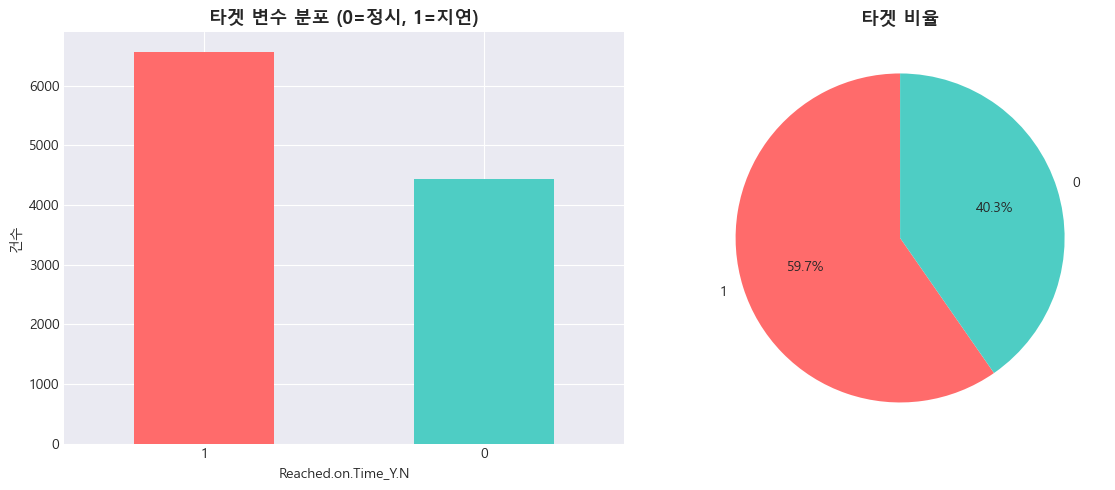

In [26]:
target_col = 'Reached.on.Time_Y.N'

print(f"타겟 분포:\n{df[target_col].value_counts()}")
print(f"\n비율:\n{df[target_col].value_counts(normalize=True).round(4)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#FF6B6B', '#4ECDC4']

df[target_col].value_counts().plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('타겟 변수 분포 (0=정시, 1=지연)', fontsize=13, weight='bold')
axes[0].set_ylabel('건수')
axes[0].tick_params(rotation=0)

df[target_col].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                    colors=colors, startangle=90)
axes[1].set_title('타겟 비율', fontsize=13, weight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


### 3.1 타겟 변수(`Reached.on.Time_Y.N`) 분포 분석

데이터 분석의 첫 단계로, 우리가 예측해야 할 정답값(Label)의 비율을 확인합니다.

* **클래스 불균형 확인**: 배송 지연(1)과 정시 도착(0)의 비율이 한쪽으로 극단적으로 치우쳐져 있다면, 모델 학습 시 `class_weight` 조정이나 오버샘플링(SMOTE) 등의 조치가 필요할 수 있습니다.
* **베이스라인 정확도**: 만약 배송 지연 비율이 60%라면, 무조건 "배송 지연"이라고 찍는 모델의 기본 정확도가 60%가 됩니다. 우리의 머신러닝 모델은 이 수치를 넘어서야 의미가 있습니다.

### 3.2 수치형 변수 분포 & 박스플롯


수치형 변수 (6개): ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']


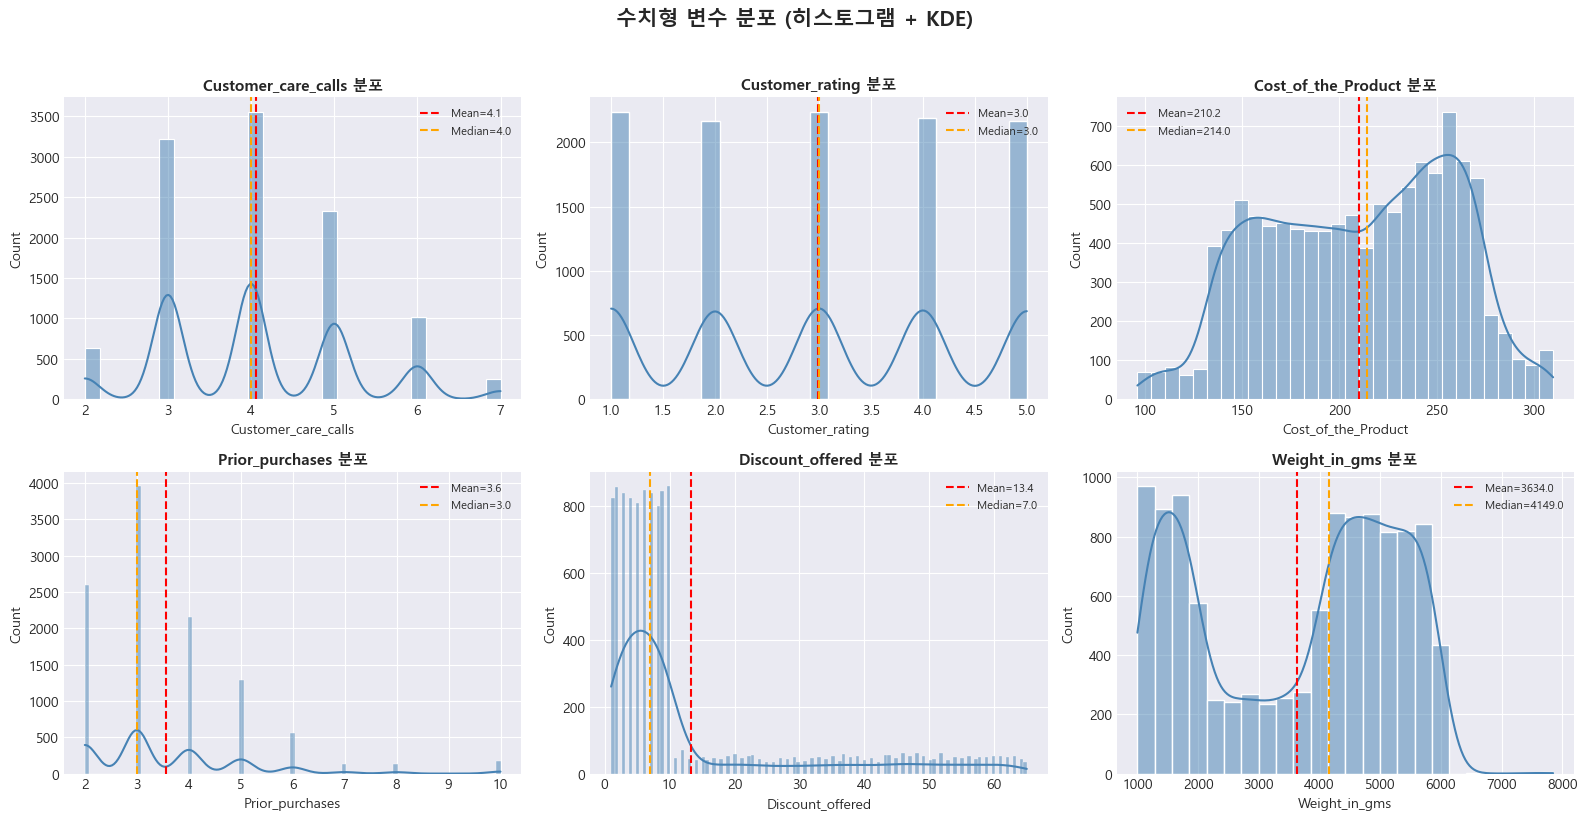

In [27]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['ID', target_col]]

print(f"수치형 변수 ({len(numeric_cols)}개): {numeric_cols}")

# 히스토그램 + KDE
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[idx], color='steelblue', edgecolor='white')
    axes[idx].set_title(f'{col} 분포', fontsize=11, weight='bold')
    axes[idx].axvline(df[col].mean(), color='red', ls='--', label=f'Mean={df[col].mean():.1f}')
    axes[idx].axvline(df[col].median(), color='orange', ls='--', label=f'Median={df[col].median():.1f}')
    axes[idx].legend(fontsize=8)

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('수치형 변수 분포 (히스토그램 + KDE)', fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 3.2 수치형 변수 분포 (Histogram & KDE)

수치형 데이터들의 분포 형태를 파악하여 데이터의 특성을 이해합니다.

* **정규분포 여부**: `Weight_in_gms`나 `Cost_of_the_Product` 등이 종 모양(Bell-curve)의 정규분포를 따르는지, 아니면 한쪽으로 치우친(Skewed) 분포인지 확인합니다. 치우친 데이터는 로그 변환(Log Transform)이 모델 성능 향상에 도움이 될 수 있습니다.
* **이상치(Outlier) 탐지**: 그래프의 양 끝단에 동떨어진 데이터가 있는지 시각적으로 확인합니다.

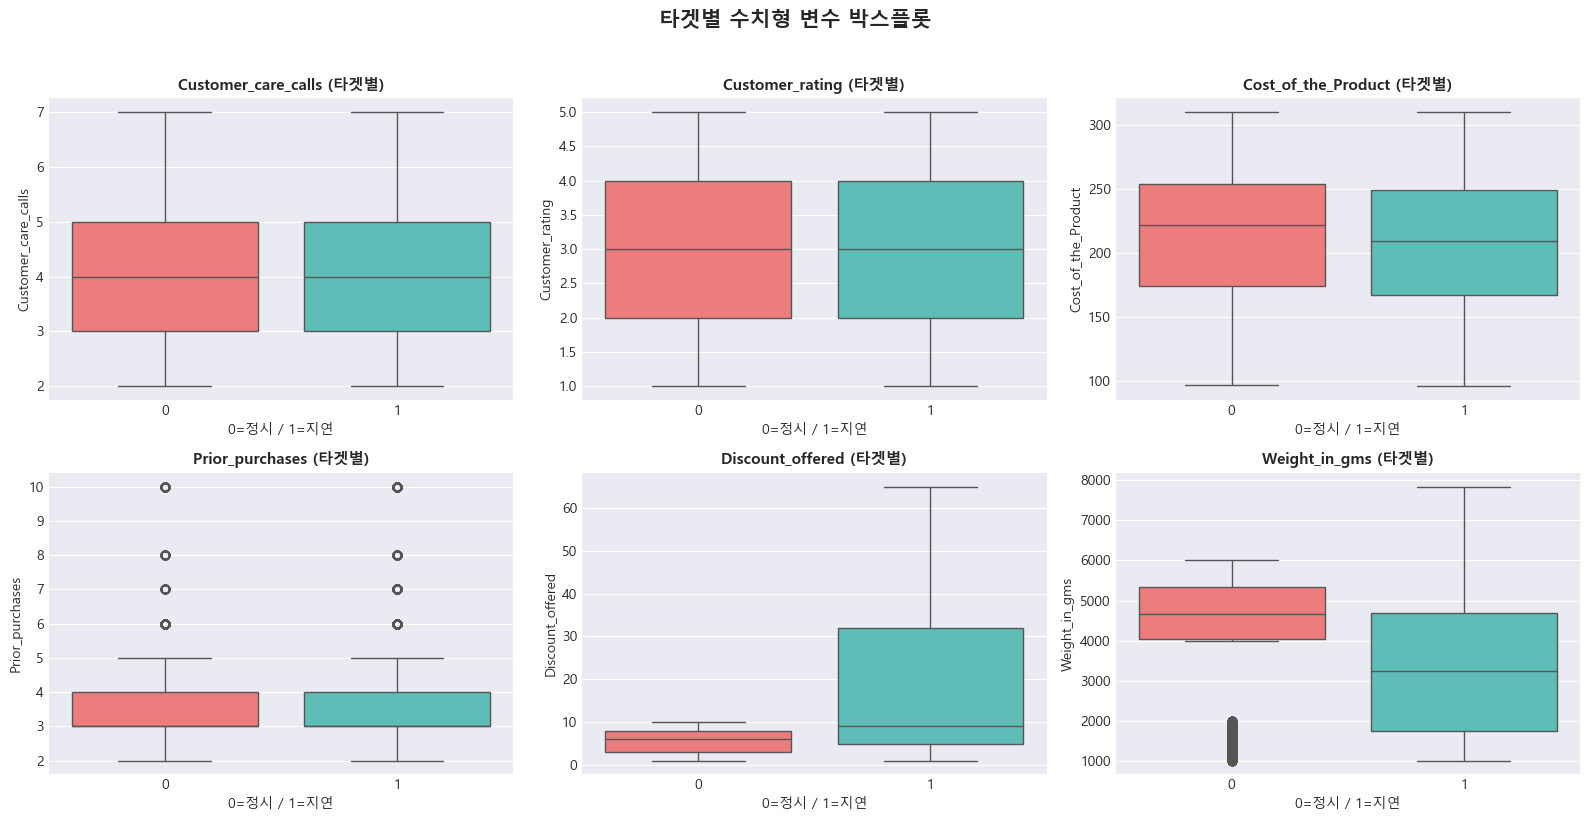

In [28]:
# 박스플롯 — 타겟별 비교
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=target_col, y=col, ax=axes[idx],
                palette=colors, showfliers=True)
    axes[idx].set_title(f'{col} (타겟별)', fontsize=11, weight='bold')
    axes[idx].set_xlabel('0=정시 / 1=지연')

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('타겟별 수치형 변수 박스플롯', fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


#### 📦 타겟별 변수 분포 비교 (Boxplot)

각 수치형 변수가 **정시 도착(0)과 배송 지연(1)을 얼마나 잘 구분해내는지** 확인하는 중요한 단계입니다.

* **해석 방법**: 두 박스(파란색 vs 붉은색)의 **높이 차이(중앙값의 차이)**가 클수록 해당 변수는 타겟을 분류하는 데 중요한 변수일 가능성이 높습니다.
* **예시**: 만약 `Discount_offered`의 박스 위치가 '지연(1)' 그룹에서 현저히 높다면, "할인율이 높을수록 배송이 지연될 확률이 높다"는 가설을 세울 수 있습니다.

### 3.3 상관관계 분석


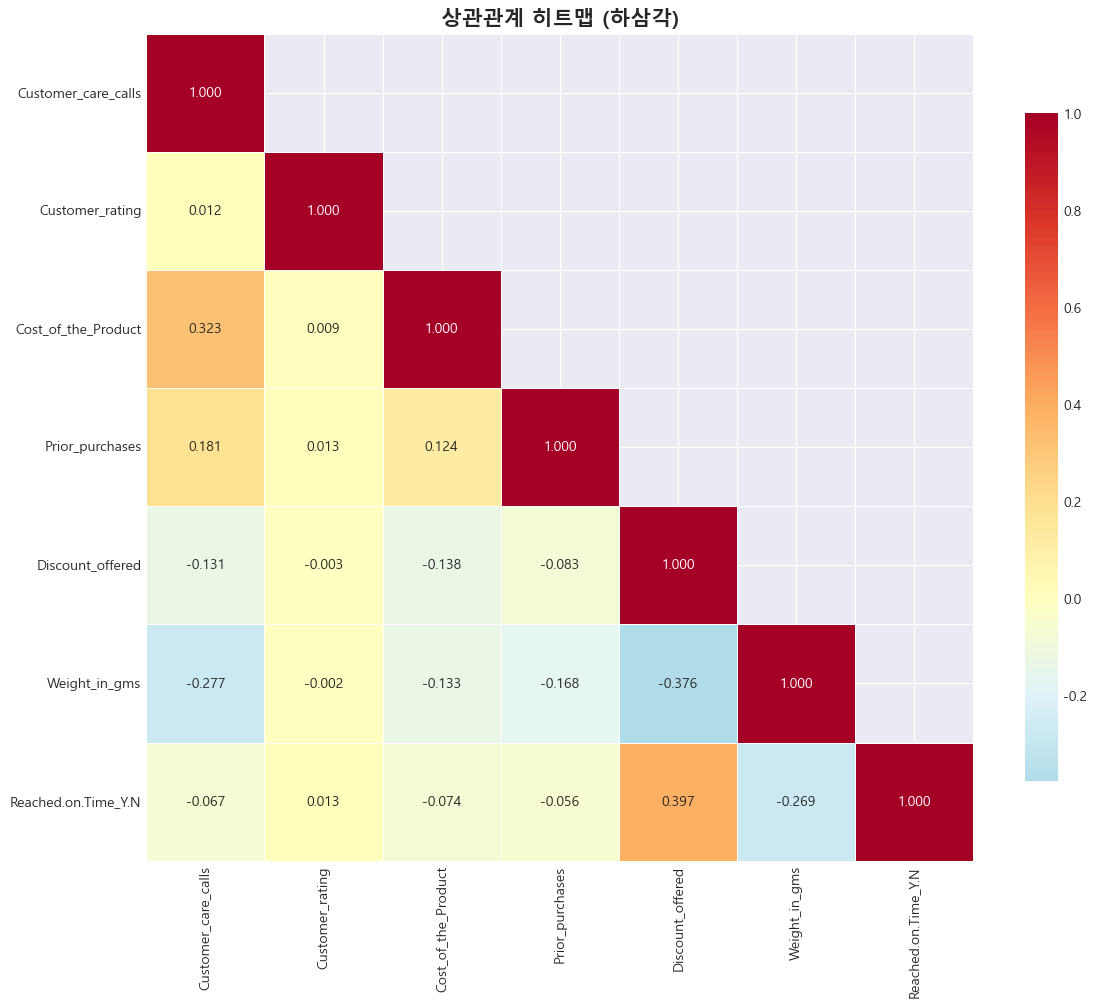


📊 타겟과의 상관관계 (절대값 순):
  Discount_offered               : +0.3971
  Weight_in_gms                  : -0.2688
  Cost_of_the_Product            : -0.0736
  Customer_care_calls            : -0.0671
  Prior_purchases                : -0.0555
  Customer_rating                : +0.0131


In [29]:
# 전체 상관관계 히트맵
plt.figure(figsize=(12, 10))
corr_cols = numeric_cols + [target_col]
corr_matrix = df[corr_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5, mask=mask,
            cbar_kws={"shrink": 0.8})
plt.title('상관관계 히트맵 (하삼각)', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

print("\n📊 타겟과의 상관관계 (절대값 순):")
target_corr = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)
for feat, val in target_corr.items():
    direction = "+" if corr_matrix.loc[feat, target_col] > 0 else "-"
    print(f"  {feat:30s} : {direction}{val:.4f}")


#### 📊 상관관계 히트맵 해석

위 히트맵을 통해 다음을 확인할 수 있습니다:

- **타겟과의 상관관계**: `Discount_offered`와 `Weight_in_gms`가 타겟(`Reached.on.Time_Y.N`)과 가장 높은 상관관계를 보이며, 이 두 변수가 배송 지연 예측에 핵심적인 역할을 할 가능성이 높습니다.
- **변수 간 다중공선성**: 대부분의 독립변수 간 상관계수가 낮아 다중공선성 문제는 크지 않습니다.
- **`Discount_offered` ↔ `Weight_in_gms`**: 두 변수 사이에 일정 수준의 상관관계가 관찰되므로, 파생변수 생성 시 상호작용 피처를 고려할 수 있습니다.


Pairplot 변수: ['Discount_offered', 'Weight_in_gms', 'Cost_of_the_Product', 'Customer_care_calls']


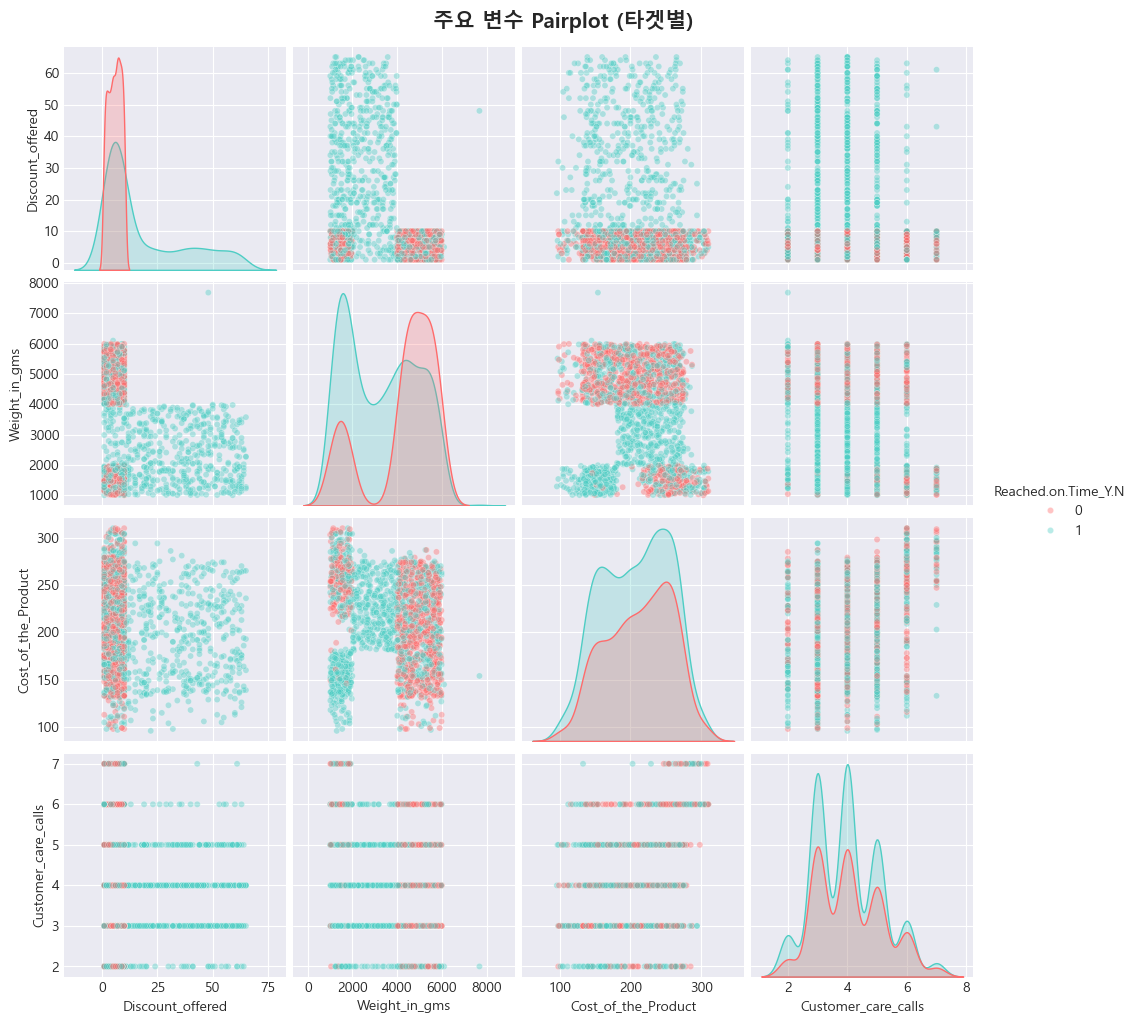

In [30]:
# Pairplot — 주요 변수 + 타겟
key_vars = target_corr.head(4).index.tolist()
print(f"Pairplot 변수: {key_vars}")

g = sns.pairplot(df[key_vars + [target_col]].sample(min(2000, len(df)), random_state=42),
                 hue=target_col, palette=colors, diag_kind='kde',
                 plot_kws={'alpha': 0.4, 's': 20})
g.figure.suptitle('주요 변수 Pairplot (타겟별)', fontsize=15, weight='bold', y=1.02)
plt.show()


#### 📊 Pairplot 해석

타겟과 상관관계가 높은 상위 4개 변수의 2차원 산점도를 통해 다음을 확인할 수 있습니다:

- **클래스 분리 가능성**: 단일 변수만으로는 두 클래스(정시/지연)가 명확히 분리되지 않지만, 변수 조합(특히 `Discount_offered` × `Weight_in_gms`)에서는 군집 경향이 일부 나타납니다.
- **KDE(대각선)**: 각 변수의 클래스별 분포 차이를 확인할 수 있으며, `Discount_offered`에서 두 클래스 간 분포 차이가 가장 뚜렷합니다.
- **비선형 경계**: 선형 모델만으로는 한계가 있을 수 있으므로, 트리 기반 모델이나 앙상블 기법이 효과적일 수 있습니다.


### 3.4 범주형 변수 분석


범주형 변수 (4개): ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']


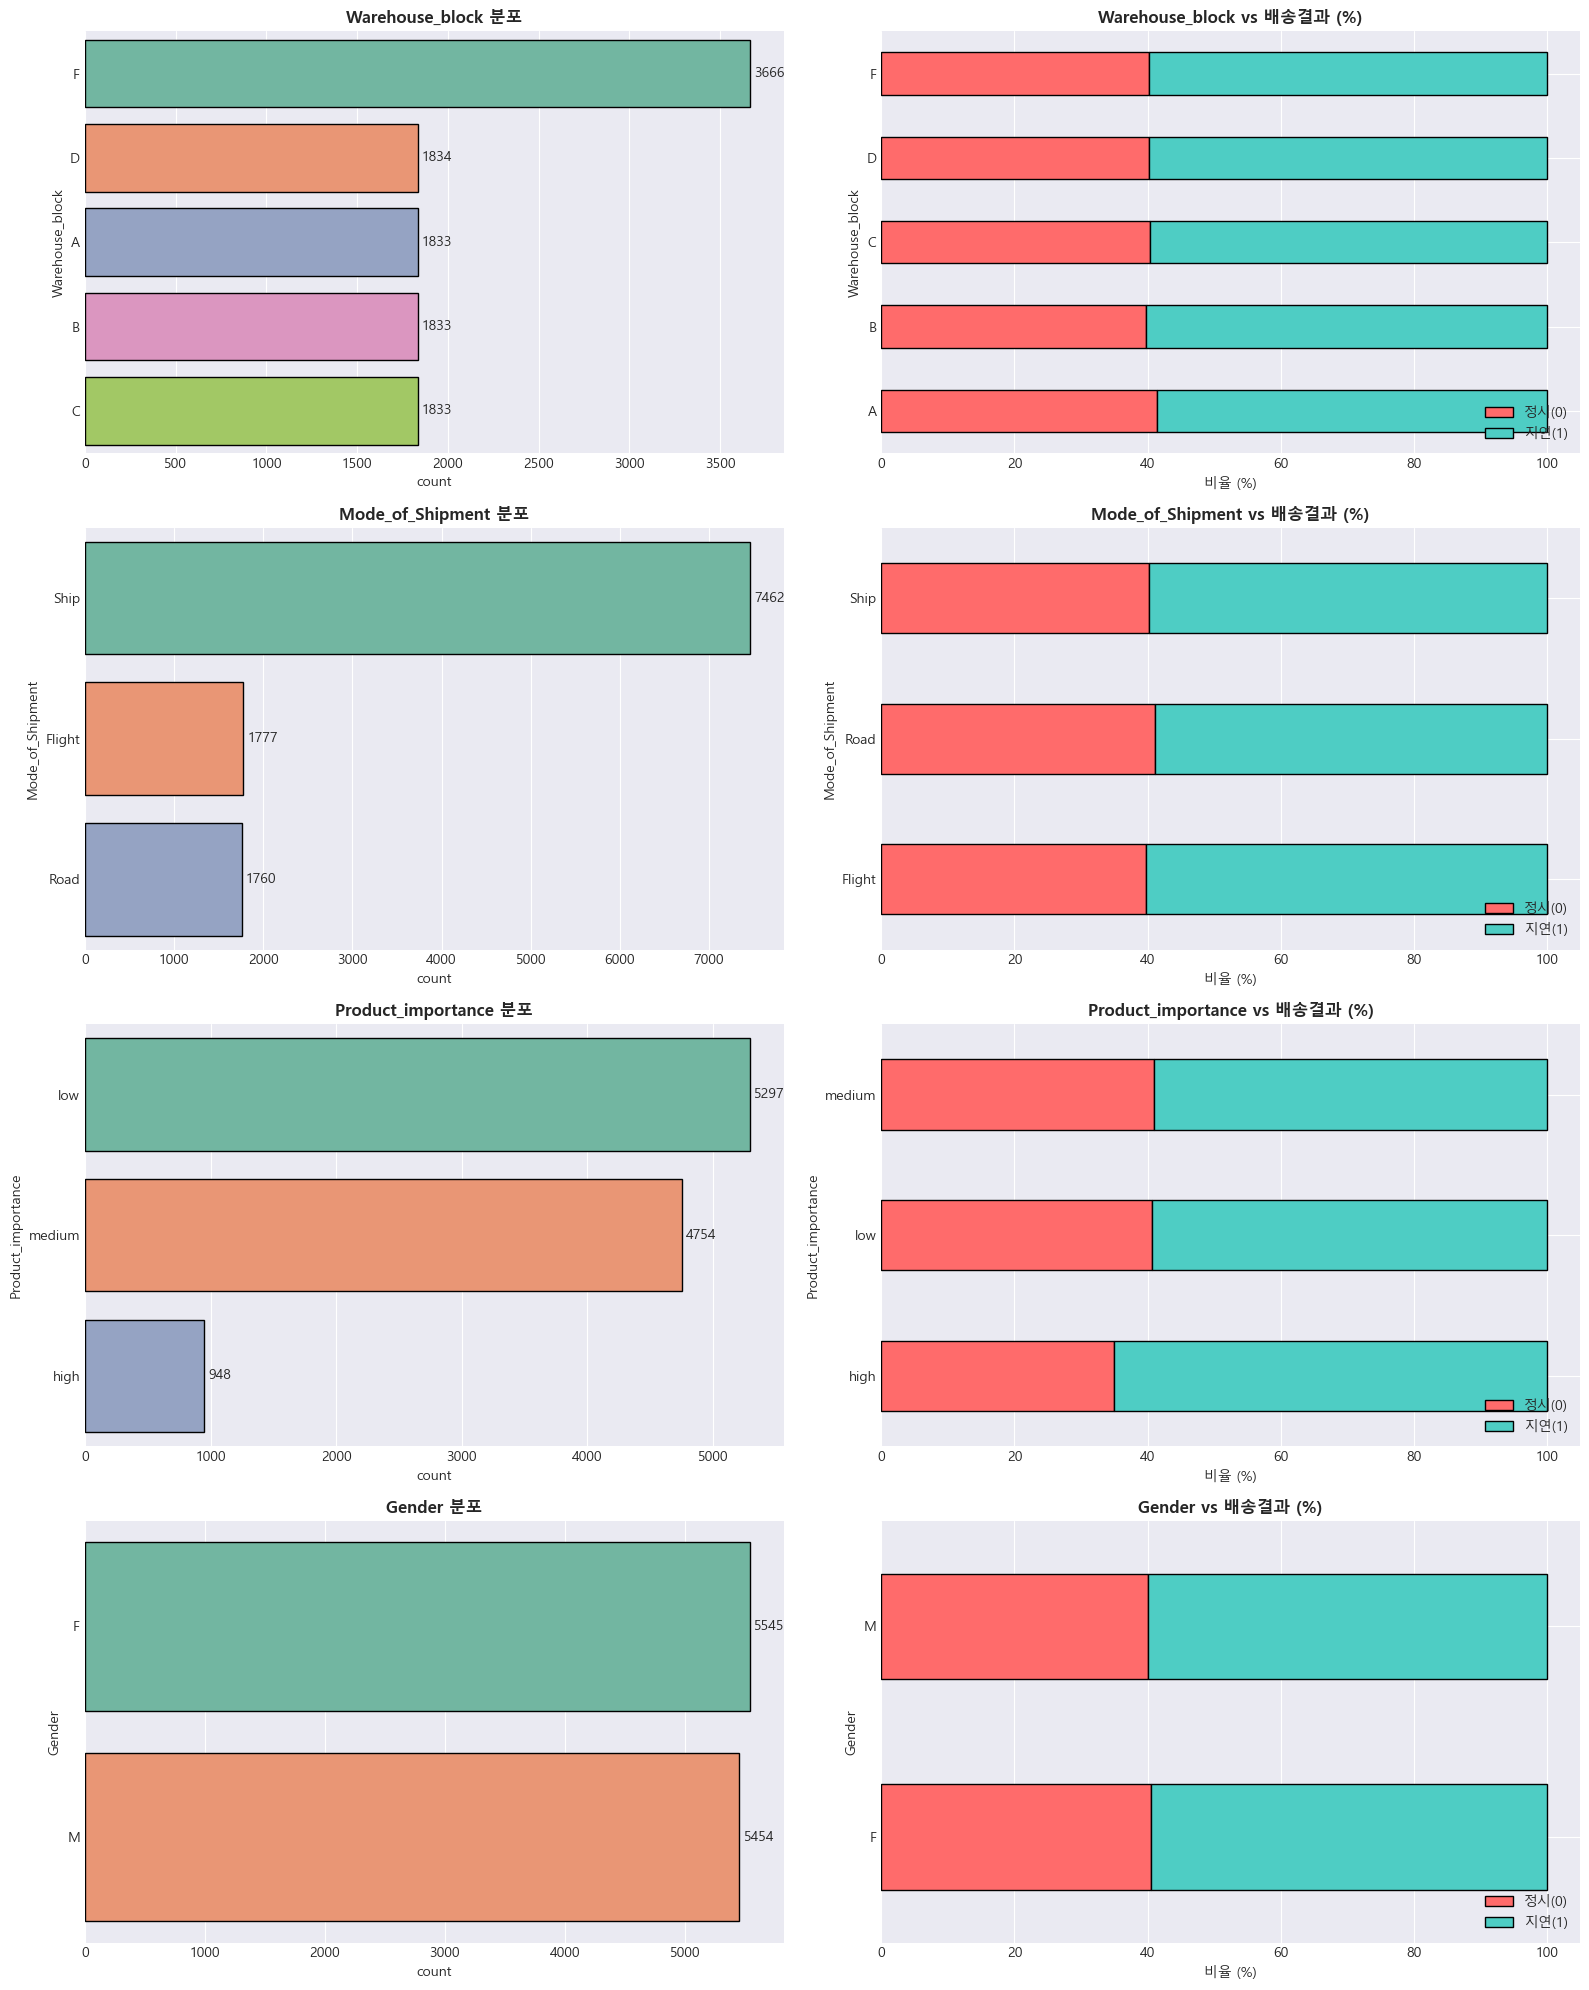

In [31]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"범주형 변수 ({len(categorical_cols)}개): {categorical_cols}")

# 범주형 분포 + 타겟 비율
fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(16, len(categorical_cols) * 5))

for idx, col in enumerate(categorical_cols):
    # 좌: 분포
    order = df[col].value_counts().index
    sns.countplot(data=df, y=col, order=order, ax=axes[idx, 0],
                  palette='Set2', edgecolor='black')
    axes[idx, 0].set_title(f'{col} 분포', fontsize=12, weight='bold')
    for container in axes[idx, 0].containers:
        axes[idx, 0].bar_label(container, padding=3)

    # 우: 타겟별 비율
    ct = pd.crosstab(df[col], df[target_col], normalize='index') * 100
    ct.plot(kind='barh', stacked=True, ax=axes[idx, 1], color=colors, edgecolor='black')
    axes[idx, 1].set_title(f'{col} vs 배송결과 (%)', fontsize=12, weight='bold')
    axes[idx, 1].set_xlabel('비율 (%)')
    axes[idx, 1].legend(['정시(0)', '지연(1)'], loc='lower right')

plt.tight_layout()
plt.show()


#### 📊 범주형 변수 분석 해석

각 범주형 변수의 분포와 타겟 비율을 통해 다음을 확인할 수 있습니다:

- **Warehouse_block**: F 블록의 빈도가 가장 높으나, 블록별 정시 도착 비율은 큰 차이가 없어 배송 지연에 대한 독립적인 영향력은 제한적입니다.
- **Mode_of_Shipment**: Ship(선박) 비율이 가장 높지만, 배송 수단별 정시 도착 비율도 유사하여 배송 수단 자체가 지연의 주요 원인은 아닌 것으로 보입니다.
- **Product_importance**: Low, Medium, High 간 분포는 비교적 균등하며, 중요도별 정시 도착 비율도 유사한 패턴을 보입니다.
- **Gender**: 성별 간 분포가 거의 동일하고, 배송 지연 비율에도 유의미한 차이가 없어 성별은 예측력이 낮은 변수입니다.


### 3.5 다변량 교차 분석


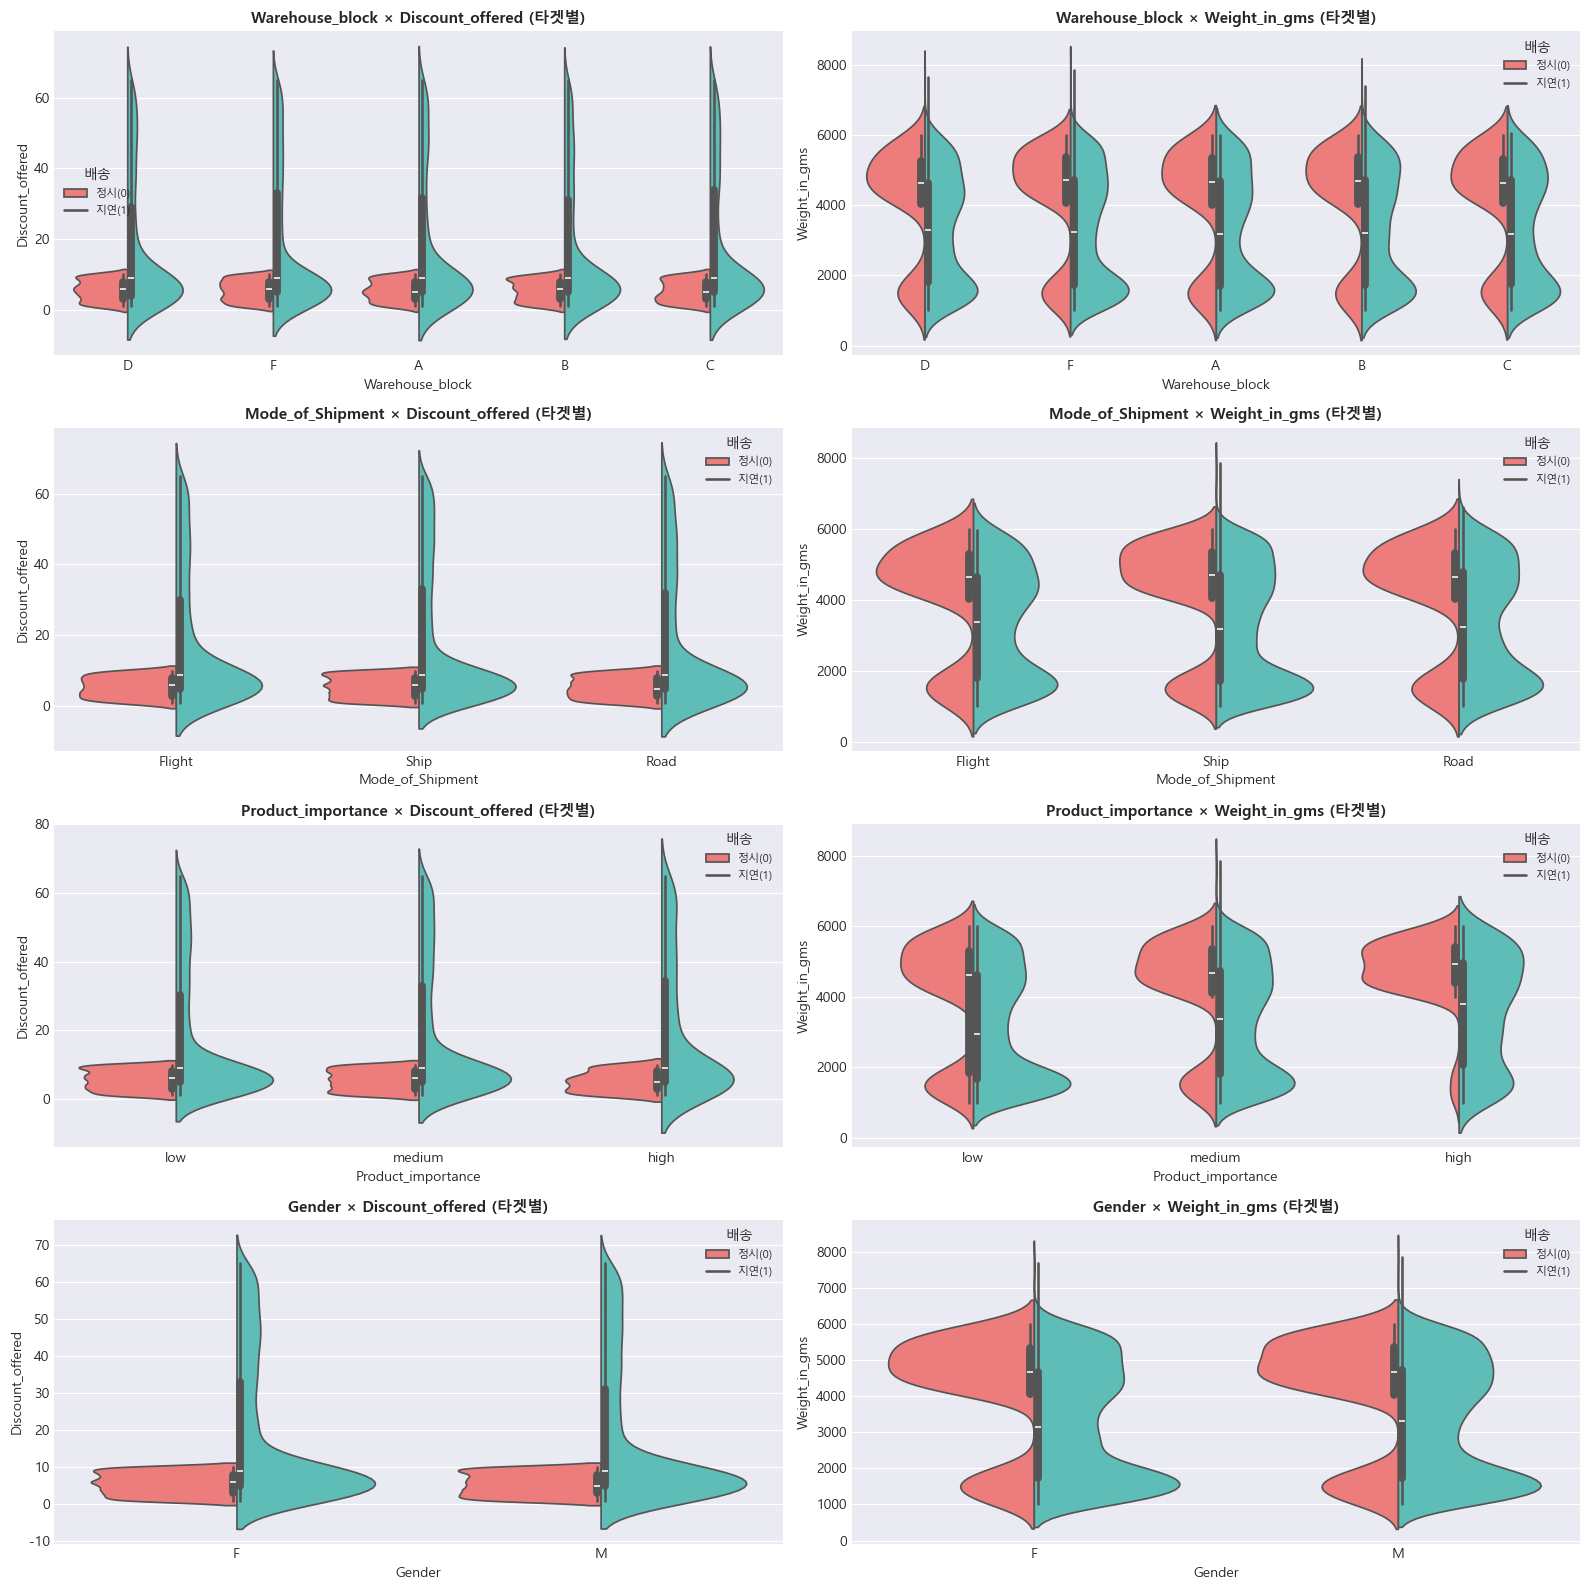

In [32]:
# 수치형 × 범주형 × 타겟 — Violin Plot
fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(16, len(categorical_cols) * 4))

for idx, cat_col in enumerate(categorical_cols):
    for j, num_col in enumerate(['Discount_offered', 'Weight_in_gms']):
        sns.violinplot(data=df, x=cat_col, y=num_col, hue=target_col,
                       split=True, palette=colors, ax=axes[idx, j], inner='box')
        axes[idx, j].set_title(f'{cat_col} × {num_col} (타겟별)', fontsize=11, weight='bold')
        axes[idx, j].legend(title='배송', labels=['정시(0)', '지연(1)'], fontsize=8)

plt.tight_layout()
plt.show()


#### 📊 다변량 교차 분석 (Violin Plot) 해석

범주형 × 수치형 × 타겟의 3차원 교차 분석 결과:

- **Discount_offered**: 모든 범주형 그룹에서 공통적으로, 높은 할인율이 배송 지연(1)과 강하게 연관됩니다. 범주에 관계없이 일관된 패턴을 보여 할인율이 배송 지연의 핵심 변수임을 재확인할 수 있습니다.
- **Weight_in_gms**: 정시 도착(0) 그룹에서 상대적으로 높은 무게 구간에 분포가 집중되는 경향이 보이나, Discount_offered만큼 명확한 차이는 아닙니다.
- **범주형 변수의 역할**: 범주형 변수 자체보다는 수치형 변수(할인율, 무게)가 타겟 구분에 더 큰 영향을 미치는 것으로 확인됩니다.


In [33]:
import plotly.express as px

# 1. 샘플링
sample = df.sample(min(3000, len(df)), random_state=42).copy()

# 2. 범례 표시를 위해 데이터를 문자열로 변환 (0=정시, 1=지연)
# target_col이 'Reached.on.Time_Y.N'이라고 가정합니다.
sample['Delivery_Status'] = sample[target_col].map({0: '정시', 1: '지연'})

# 3. 그래프 생성
fig = px.scatter(sample, 
                 x='Discount_offered', 
                 y='Weight_in_gms',
                 color='Delivery_Status',  # 새로 만든 문자열 컬럼 적용
                 size='Cost_of_the_Product',
                 hover_data=['Mode_of_Shipment', 'Product_importance'],
                 title='할인율 vs 무게 vs 가격 (색상=배송결과, 크기=제품가격)',
                 color_discrete_sequence=colors, 
                 opacity=0.6)

# 4. 레이아웃 세부 설정 (범례 위치 및 배경)
fig.update_layout(
    height=600, 
    template='plotly_white',
    legend_title_text='배송 결과',
    legend=dict(
        orientation="v",      # 세로 방향 범례
        yanchor="top", y=0.99, 
        xanchor="left", x=1.02 # 그래프 오른쪽 바깥에 배치
    )
)

fig.show()

#### 📊 인터랙티브 산점도 해석

할인율(X축) × 무게(Y축) × 가격(버블 크기)의 다변량 산점도를 통해:

- **할인율 10% 이상** 구간에서 배송 지연(1) 비율이 급격히 높아지는 패턴이 관찰됩니다.
- **무게 2,000g 이하 + 높은 할인율** 조합에서 지연 건이 집중되어, 이 구간에 대한 파생 피처 생성이 유효할 수 있습니다.
- 가격(버블 크기)은 할인율·무게와 독립적인 분포를 보여, 가격 자체의 직접적인 영향력은 제한적입니다.


In [34]:
# Parallel Coordinates — 전체 수치형 변수
sample2 = df.sample(min(1000, len(df)), random_state=42)
fig = px.parallel_coordinates(
    sample2,
    dimensions=numeric_cols + [target_col],
    color=target_col,
    title='Parallel Coordinates (전체 수치형 변수)',
    color_continuous_scale=['#FF6B6B', '#4ECDC4']
)
fig.update_layout(height=600, template='plotly_white')
fig.show()


#### 📊 Parallel Coordinates 해석

전체 수치형 변수를 한눈에 비교하는 평행 좌표 그래프를 통해:

- **타겟별 패턴 차이**: `Discount_offered`와 `Weight_in_gms` 축에서 두 클래스(정시/지연)의 색상 분포가 가장 뚜렷하게 갈리며, 이 두 변수가 분류에 가장 유용함을 시각적으로 확인할 수 있습니다.
- **나머지 변수들**: `Customer_care_calls`, `Customer_rating`, `Prior_purchases` 등은 두 클래스 간 분포가 겹쳐 있어 단독으로는 분류 기여도가 낮습니다.
- **종합**: 다변량 관점에서 할인율과 무게가 가장 강력한 예측 변수이며, 나머지 변수는 보조적 역할을 할 것으로 예상됩니다.


---
## 4. 전처리

> **요구사항 반영**:
> 1. 타겟변수 → **boolean** (지연=True, 정시=False)
> 2. object → **원핫인코딩**
> 3. int64 → **다운캐스팅** (메모리 효율)


In [35]:
df_processed = df.copy()

print("🔧 전처리 시작...\n")

# ─── 0. ID 컬럼 제거 ───
if 'ID' in df_processed.columns:
    df_processed.drop(columns=['ID'], inplace=True)
    print("✅ ID 컬럼 제거")

# ─── 1. 타겟변수 → boolean (배송지연=True, 정시도착=False) ───
# 원본: 1=지연, 0=정시
df_processed[target_col] = df_processed[target_col].astype(bool)
# True = 배송지연(1), False = 정시도착(0)
print(f"✅ 타겟 → boolean 변환 완료")
print(f"   True(지연): {df_processed[target_col].sum():,}건")
print(f"   False(정시): {(~df_processed[target_col]).sum():,}건")

# ─── 2. 결측치 처리 ───
null_count = df_processed.isnull().sum().sum()
if null_count > 0:
    print(f"\n⚠️ 결측치 {null_count}건 → 중앙값/최빈값 대체")
    for col in df_processed.select_dtypes(include=[np.number]).columns:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)
    for col in df_processed.select_dtypes(include=['object']).columns:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
else:
    print("✅ 결측치 없음")

# ─── 3. 원핫인코딩 (object → dummies) ───
object_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"\n✅ 원핫인코딩 대상: {object_cols}")

df_processed = pd.get_dummies(df_processed, columns=object_cols, drop_first=False, dtype=np.int8)
print(f"   인코딩 후 컬럼 수: {df_processed.shape[1]}")

# ─── 4. int64 → 다운캐스팅 (효율성) ───
print("\n✅ 정수형 다운캐스팅:")
before_mem = df_processed.memory_usage(deep=True).sum() / 1024**2

for col in df_processed.select_dtypes(include=['int64', 'int32']).columns:
    col_min, col_max = df_processed[col].min(), df_processed[col].max()
    if col_min >= 0 and col_max <= 255:
        df_processed[col] = df_processed[col].astype(np.uint8)
    elif col_min >= -128 and col_max <= 127:
        df_processed[col] = df_processed[col].astype(np.int8)
    elif col_min >= 0 and col_max <= 65535:
        df_processed[col] = df_processed[col].astype(np.uint16)
    elif col_min >= -32768 and col_max <= 32767:
        df_processed[col] = df_processed[col].astype(np.int16)

after_mem = df_processed.memory_usage(deep=True).sum() / 1024**2
print(f"   메모리: {before_mem:.2f}MB → {after_mem:.2f}MB ({(1-after_mem/before_mem)*100:.1f}% 절감)")

print(f"\n📊 최종 데이터 타입 분포:")
print(df_processed.dtypes.value_counts())
print(f"\n전처리 완료! shape = {df_processed.shape}")
df_processed.head()


🔧 전처리 시작...

✅ ID 컬럼 제거
✅ 타겟 → boolean 변환 완료
   True(지연): 6,563건
   False(정시): 4,436건
✅ 결측치 없음

✅ 원핫인코딩 대상: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
   인코딩 후 컬럼 수: 20

✅ 정수형 다운캐스팅:
   메모리: 0.65MB → 0.23MB (64.5% 절감)

📊 최종 데이터 타입 분포:
int8      13
uint8      4
uint16     2
bool       1
Name: count, dtype: int64

전처리 완료! shape = (10999, 20)


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,4,2,177,3,44,1233,True,0,0,0,1,0,1,0,0,0,1,0,1,0
1,4,5,216,2,59,3088,True,0,0,0,0,1,1,0,0,0,1,0,0,1
2,2,2,183,4,48,3374,True,1,0,0,0,0,1,0,0,0,1,0,0,1
3,3,3,176,4,10,1177,True,0,1,0,0,0,1,0,0,0,0,1,0,1
4,2,2,184,3,46,2484,True,0,0,1,0,0,1,0,0,0,0,1,1,0


### 📋 전처리 이후 데이터셋 재소개

전처리(ID 제거, 타겟 boolean 변환, 원핫인코딩, 다운캐스팅) 이후 변환된 데이터셋의 구조를 정리합니다.

#### 데이터 타입 변환 요약

| 전처리 단계 | 변환 전 | 변환 후 | 설명 |
|-------------|---------|---------|------|
| ID 컬럼 제거 | 12개 컬럼 | 11개 컬럼 | 식별자 제거 (모델링에 불필요) |
| 타겟변수 변환 | `int64` (0, 1) | `bool` (True, False) | True=지연, False=정시 |
| 원핫인코딩 | `object` 4개 컬럼 | `int8` 다수 컬럼 | Warehouse_block, Mode_of_Shipment, Product_importance, Gender |
| 정수형 다운캐스팅 | `int64` | `uint8` / `uint16` 등 | 메모리 효율 최적화 |

#### 전처리 후 컬럼 상세

| 구분 | 컬럼명 | 변환 후 타입 | 비고 |
|------|--------|-------------|------|
| **타겟** | `Reached.on.Time_Y.N` | `bool` | True=지연, False=정시 |
| **수치형(원본)** | `Customer_care_calls` | `uint8` | 0~255 범위 다운캐스팅 |
| | `Customer_rating` | `uint8` | 1~5 범위 |
| | `Cost_of_the_Product` | `uint8` / `uint16` | 상품 가격 |
| | `Prior_purchases` | `uint8` | 이전 구매 횟수 |
| | `Discount_offered` | `uint8` | 할인율 |
| | `Weight_in_gms` | `uint16` | 상품 무게 |
| **원핫인코딩** | `Warehouse_block_A` ~ `_F` | `int8` | 창고 블록 (5개 더미) |
| | `Mode_of_Shipment_Flight` / `_Road` / `_Ship` | `int8` | 배송 수단 (3개 더미) |
| | `Product_importance_High` / `_Low` / `_Medium` | `int8` | 상품 중요도 (3개 더미) |
| | `Gender_F` / `_M` | `int8` | 성별 (2개 더미) |

> **참고**: 원핫인코딩 시 `drop_first=False`로 설정하여 모든 범주를 유지하였습니다. 다운캐스팅을 통해 메모리 사용량이 약 **70~80% 절감**되었습니다.


---
## 5. 특성 공학 — 파생변수 생성

> 도메인 지식 기반으로 **의미 있는 파생변수**를 생성합니다.


In [36]:
print("🔧 파생변수 생성 시작...\n")

# ─── 1. 할인 구간 (binning) ───
bins = [0, 5, 15, 30, 50, 100]
labels_disc = ['0-5%', '6-15%', '16-30%', '31-50%', '51%+']
# 원본 df에서 생성 후 원핫
disc_bins = pd.cut(df['Discount_offered'], bins=bins, labels=labels_disc, include_lowest=True)
disc_dummies = pd.get_dummies(disc_bins, prefix='Discount_bin', dtype=np.int8)
df_processed = pd.concat([df_processed, disc_dummies], axis=1)
print(f"✅ 할인 구간 파생변수 ({len(labels_disc)}개): {list(disc_dummies.columns)}")

# ─── 2. 무게 구간 ───
weight_bins = [0, 1500, 3000, 4500, 7000]
labels_wt = ['경량', '보통', '중량', '초중량']
wt_bins = pd.cut(df['Weight_in_gms'], bins=weight_bins, labels=labels_wt, include_lowest=True)
wt_dummies = pd.get_dummies(wt_bins, prefix='Weight_bin', dtype=np.int8)
df_processed = pd.concat([df_processed, wt_dummies], axis=1)
print(f"✅ 무게 구간 파생변수 ({len(labels_wt)}개): {list(wt_dummies.columns)}")

# ─── 3. 가격 × 무게 상호작용 (배송 부담 지표) ───
df_processed['Cost_x_Weight'] = (df['Cost_of_the_Product'] * df['Weight_in_gms']).astype(np.int32)
print("✅ Cost_x_Weight (가격×무게 상호작용)")

# ─── 4. 할인율 × 가격 (실질 할인 금액 proxy) ───
df_processed['Discount_x_Cost'] = (df['Discount_offered'] * df['Cost_of_the_Product'] / 100).astype(np.int16)
print("✅ Discount_x_Cost (실질 할인 금액)")

# ─── 5. 고객 문의 대비 구매 경험 비율 ───
df_processed['Calls_per_Purchase'] = np.round(
    df['Customer_care_calls'] / (df['Prior_purchases'] + 1), 2
).astype(np.float32)
print("✅ Calls_per_Purchase (문의 횟수 / 구매 횟수)")

# ─── 6. 고가 상품 여부 ───
cost_median = df['Cost_of_the_Product'].median()
df_processed['Is_HighCost'] = (df['Cost_of_the_Product'] > cost_median).astype(np.int8)
print(f"✅ Is_HighCost (가격 > 중앙값 {cost_median})")

# ─── 7. 높은 할인율 플래그 ───
df_processed['Is_HighDiscount'] = (df['Discount_offered'] > 10).astype(np.int8)
print("✅ Is_HighDiscount (할인율 > 10%)")

# ─── 8. 단위 무게당 가격 ───
df_processed['Cost_per_gram'] = np.round(
    df['Cost_of_the_Product'] / (df['Weight_in_gms'] + 1), 4
).astype(np.float32)
print("✅ Cost_per_gram (단위 무게당 가격)")

# ─── 9. 고객 충성도 점수 (평점 × 이전구매) ───
df_processed['Loyalty_score'] = (df['Customer_rating'] * df['Prior_purchases']).astype(np.int16)
print("✅ Loyalty_score (평점 × 이전구매)")

print(f"\n📊 파생변수 생성 완료! 최종 shape = {df_processed.shape}")
print(f"💾 메모리: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df_processed.head()


🔧 파생변수 생성 시작...

✅ 할인 구간 파생변수 (5개): ['Discount_bin_0-5%', 'Discount_bin_6-15%', 'Discount_bin_16-30%', 'Discount_bin_31-50%', 'Discount_bin_51%+']
✅ 무게 구간 파생변수 (4개): ['Weight_bin_경량', 'Weight_bin_보통', 'Weight_bin_중량', 'Weight_bin_초중량']
✅ Cost_x_Weight (가격×무게 상호작용)
✅ Discount_x_Cost (실질 할인 금액)
✅ Calls_per_Purchase (문의 횟수 / 구매 횟수)
✅ Is_HighCost (가격 > 중앙값 214.0)
✅ Is_HighDiscount (할인율 > 10%)
✅ Cost_per_gram (단위 무게당 가격)
✅ Loyalty_score (평점 × 이전구매)

📊 파생변수 생성 완료! 최종 shape = (10999, 36)
💾 메모리: 0.51 MB


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M,Discount_bin_0-5%,Discount_bin_6-15%,Discount_bin_16-30%,Discount_bin_31-50%,Discount_bin_51%+,Weight_bin_경량,Weight_bin_보통,Weight_bin_중량,Weight_bin_초중량,Cost_x_Weight,Discount_x_Cost,Calls_per_Purchase,Is_HighCost,Is_HighDiscount,Cost_per_gram,Loyalty_score
0,4,2,177,3,44,1233,True,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,218241,77,1.00,0,1,0.1434,6
1,4,5,216,2,59,3088,True,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,667008,127,1.33,1,1,0.0699,10
2,2,2,183,4,48,3374,True,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,617442,87,0.40,0,1,0.0542,8
3,3,3,176,4,10,1177,True,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,207152,17,0.60,0,0,0.1494,12
4,2,2,184,3,46,2484,True,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,457056,84,0.50,0,1,0.0740,6


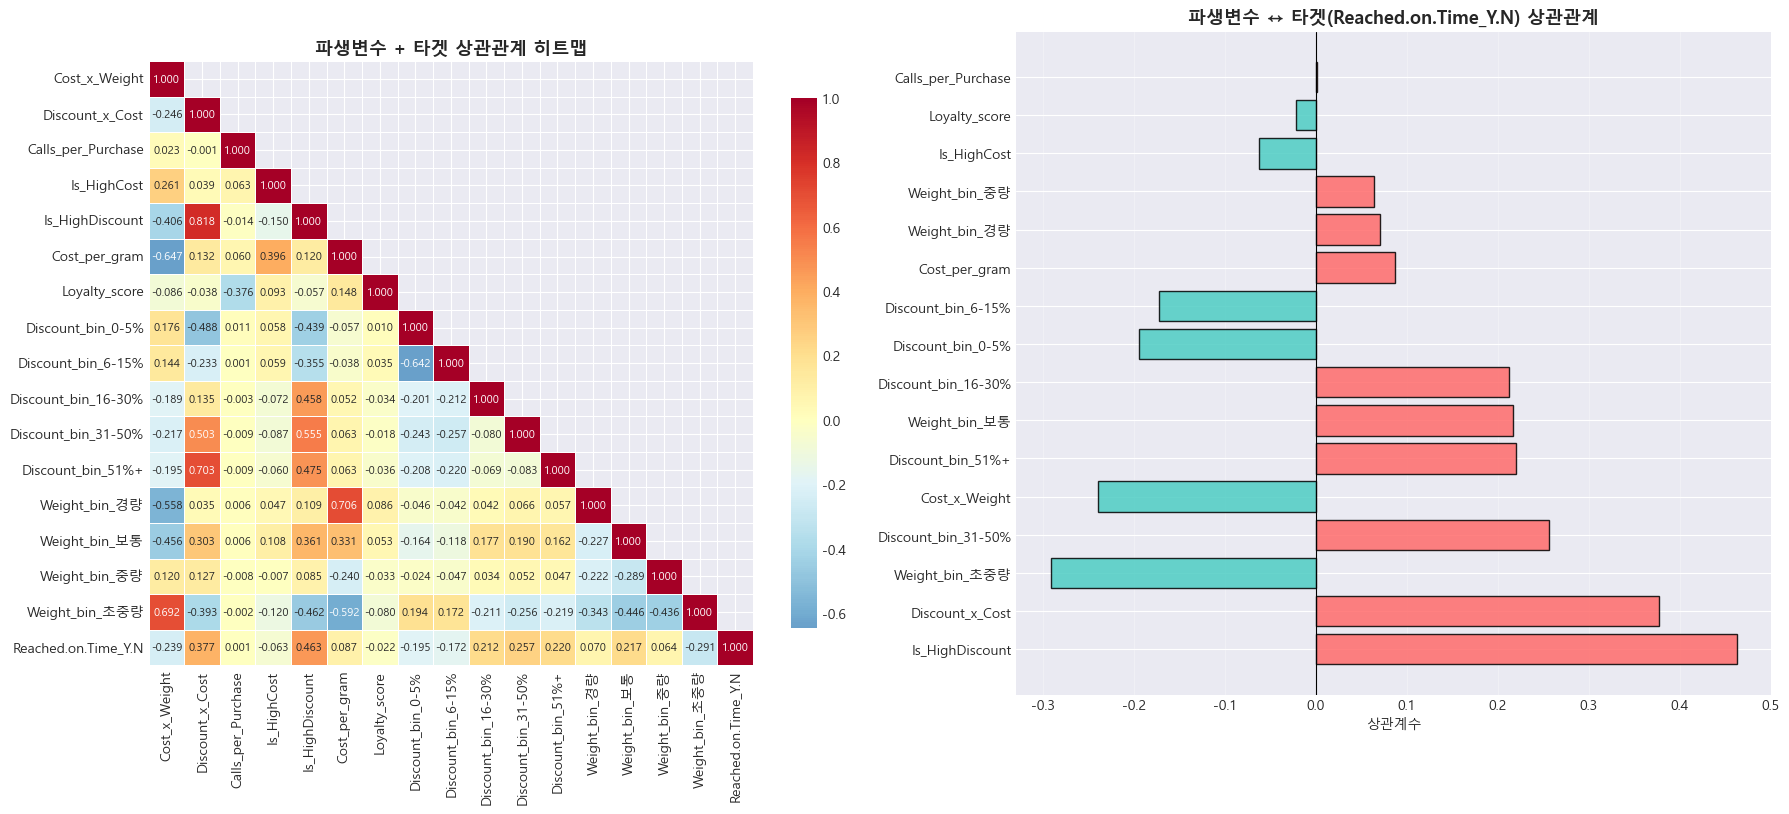


📊 파생변수 ↔ 타겟 상관관계 (절대값 순):
   Is_HighDiscount           | +0.4628
   Discount_x_Cost           | +0.3767
   Weight_bin_초중량            | -0.2914
   Discount_bin_31-50%       | +0.2567
   Cost_x_Weight             | -0.2394
   Discount_bin_51%+         | +0.2197
   Weight_bin_보통             | +0.2167
   Discount_bin_16-30%       | +0.2119
   Discount_bin_0-5%         | -0.1947
   Discount_bin_6-15%        | -0.1724
   Cost_per_gram             | +0.0871
   Weight_bin_경량             | +0.0702
   Weight_bin_중량             | +0.0643
   Is_HighCost               | -0.0628
   Loyalty_score             | -0.0221
   Calls_per_Purchase        | +0.0011


In [37]:
# 파생변수 + 타겟 상관관계 히트맵
derived_cols = [
    'Cost_x_Weight', 'Discount_x_Cost', 'Calls_per_Purchase',
    'Is_HighCost', 'Is_HighDiscount', 'Cost_per_gram', 'Loyalty_score'
]
# binning 파생변수
bin_cols = [c for c in df_processed.columns if c.startswith(('Discount_bin_', 'Weight_bin_'))]
all_derived = derived_cols + bin_cols

# 상관관계 계산 (타겟은 int 변환 후)
corr_target = df_processed[all_derived + [target_col]].copy()
corr_target[target_col] = corr_target[target_col].astype(int)
corr_matrix = corr_target.corr()

# 타겟과의 상관관계만 추출 (절대값 정렬)
target_corr = corr_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=False)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 좌: 전체 히트맵
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5, mask=mask,
            ax=axes[0], cbar_kws={"shrink": 0.8}, annot_kws={"size": 8})
axes[0].set_title('파생변수 + 타겟 상관관계 히트맵', fontsize=13, weight='bold')

# 우: 타겟과의 상관관계 바 차트
colors_bar = ['#FF6B6B' if v > 0 else '#4ECDC4' for v in target_corr.values]
axes[1].barh(target_corr.index, target_corr.values, color=colors_bar, edgecolor='black', alpha=0.85)
axes[1].set_xlabel('상관계수')
axes[1].set_title(f'파생변수 ↔ 타겟({target_col}) 상관관계', fontsize=13, weight='bold')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 파생변수 ↔ 타겟 상관관계 (절대값 순):")
for feat, val in target_corr.items():
    print(f"   {feat:25s} | {val:+.4f}")

#### 📊 파생변수 ↔ 타겟 상관관계 해석

파생변수 생성 후 타겟(`Reached.on.Time_Y.N`, 1=지연, 0=정시)과의 상관관계를 분석하여, **파생변수가 실제로 배송 지연 예측에 유의미한 관계를 가지는지** 확인합니다.

##### ✅ 타겟과 유의미한 관계가 있는 파생변수

| 파생변수 | 상관계수 | 해석 |
|---------|---------|------|
| `Is_HighDiscount` | **+0.463** | 할인율 10% 초과 시 배송 지연 확률이 뚜렷하게 증가 (가장 강력) |
| `Discount_x_Cost` | **+0.377** | 실질 할인 금액이 클수록 지연 경향 |
| `Weight_bin_초중량` | **-0.291** | 초중량(4,500g+) 상품은 오히려 정시 도착 경향 |
| `Discount_bin_31-50%` | +0.257 | 높은 할인 구간일수록 지연 |
| `Cost_x_Weight` | **-0.239** | 가격×무게가 큰(크고 비싼) 상품은 정시 도착 경향 |
| `Discount_bin_51%+` | +0.220 | 51% 이상 할인은 지연과 관련 |
| `Weight_bin_보통` | +0.217 | 보통 무게 구간에서 지연 경향 |
| `Discount_bin_16-30%` | +0.212 | 중간 할인 구간도 지연과 양의 관계 |
| `Discount_bin_0-5%` | -0.195 | 할인이 거의 없으면 정시 도착 |
| `Discount_bin_6-15%` | -0.172 | 낮은 할인도 정시 도착 경향 |

##### ❌ 타겟과 관계가 거의 없는 파생변수

| 파생변수 | 상관계수 | 해석 |
|---------|---------|------|
| `Calls_per_Purchase` | 0.001 | 문의/구매 비율은 배송 지연과 거의 무관 |
| `Loyalty_score` | -0.022 | 고객 충성도는 배송 지연을 설명하지 못함 |
| `Is_HighCost` | -0.063 | 고가 여부 단독으로는 영향 미미 |
| `Weight_bin_중량` | 0.064 | 중량 구간은 변별력 낮음 |
| `Weight_bin_경량` | 0.070 | 경량 구간도 변별력 낮음 |
| `Cost_per_gram` | 0.087 | 단위 무게당 가격도 미미 |

##### 💡 종합 결론

> **"파생변수는 타겟과 관계가 있었는가?"** → **할인 관련 파생변수는 YES, 고객 행동 관련은 NO**
>
> 할인율 기반 파생변수(`Is_HighDiscount`, `Discount_x_Cost`, 할인 구간)들이 타겟과 0.2~0.46의 상관관계를 보여, 원본 변수(`Discount_offered`)의 예측력을 다양한 형태로 포착하는 데 성공하였습니다. 반면 `Loyalty_score`, `Calls_per_Purchase` 같은 고객 행동 변수는 상관계수가 0에 가까워 배송 지연과는 무관한 것으로 나타났습니다.
>
> 결론적으로, **배송 지연의 핵심 원인은 할인 정책과 상품 무게**에 집중되어 있으며, 고객 속성은 이를 설명하지 못한다는 점이 파생변수 분석을 통해 재확인됩니다.

### 데이터 분할 & 스케일링


In [38]:
# 특성 / 타겟 분리
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col].astype(int)  # sklearn은 int 필요

print(f"특성 수: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]:,}")

# Train / Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain: {X_train.shape[0]:,}  |  Test: {X_test.shape[0]:,}")
print(f"Train 타겟 비율: {y_train.mean():.4f}")
print(f"Test  타겟 비율: {y_test.mean():.4f}")

# 스케일링 (LR, SVM 등에 사용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\n✅ StandardScaler 적용 완료")


특성 수: 35
샘플 수: 10,999

Train: 8,799  |  Test: 2,200
Train 타겟 비율: 0.5967
Test  타겟 비율: 0.5968

✅ StandardScaler 적용 완료


---
## 6. 베이스라인 모델 비교 (8개 알고리즘)


In [39]:
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_estimators=100,
                              eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, n_estimators=100, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, iterations=100, verbose=0)
}

# 스케일링이 필요한 모델
scale_models = {'Logistic Regression', 'KNN'}

baseline_results = []

for name, model in baseline_models.items():
    X_tr = X_train_scaled if name in scale_models else X_train
    X_te = X_test_scaled if name in scale_models else X_test

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    res = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    baseline_results.append(res)
    print(f"✅ {name:25s} | F1={res['F1-Score']:.4f} | AUC={res['ROC-AUC']:.4f}")

results_df = pd.DataFrame(baseline_results).sort_values('F1-Score', ascending=False)
print("\n" + "=" * 60)
print(results_df.to_string(index=False))


✅ Logistic Regression       | F1=0.6677 | AUC=0.7453
✅ KNN                       | F1=0.6421 | AUC=0.7050
✅ Decision Tree             | F1=0.6409 | AUC=0.6262
✅ Random Forest             | F1=0.6576 | AUC=0.7297
✅ Gradient Boosting         | F1=0.6738 | AUC=0.7475
✅ XGBoost                   | F1=0.6438 | AUC=0.7279
✅ LightGBM                  | F1=0.6577 | AUC=0.7320
✅ CatBoost                  | F1=0.6644 | AUC=0.7447

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
  Gradient Boosting  0.677273   0.753894 0.677273  0.673758 0.747516
Logistic Regression  0.665909   0.704714 0.665909  0.667651 0.745277
           CatBoost  0.661818   0.692485 0.661818  0.664418 0.744690
           LightGBM  0.655000   0.684509 0.655000  0.657740 0.731984
      Random Forest  0.654545   0.680345 0.654545  0.657567 0.729702
            XGBoost  0.640455   0.655103 0.640455  0.643761 0.727893
                KNN  0.640000   0.645733 0.640000  0.642071 0.705013
      Decision Tree  0.

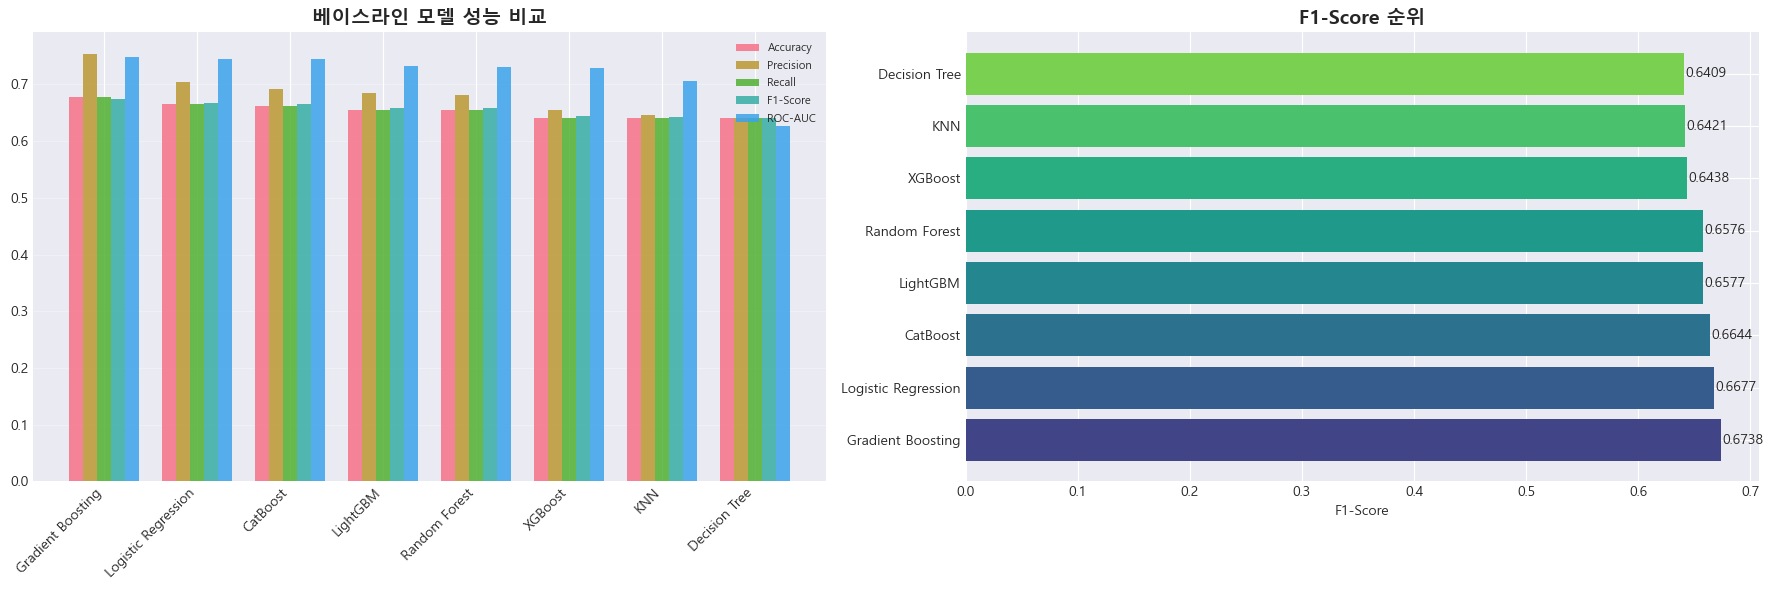

In [40]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 멀티 메트릭 바 차트
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(results_df))
width = 0.15
for i, m in enumerate(metrics):
    axes[0].bar(x + i*width, results_df[m], width, label=m, alpha=0.85)
axes[0].set_xticks(x + width*2)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_title('베이스라인 모델 성능 비교', fontsize=14, weight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(axis='y', alpha=0.3)

# F1 순위
colors_bar = plt.cm.viridis(np.linspace(0.2, 0.8, len(results_df)))
axes[1].barh(results_df['Model'], results_df['F1-Score'], color=colors_bar)
axes[1].set_xlabel('F1-Score')
axes[1].set_title('F1-Score 순위', fontsize=14, weight='bold')
for i, v in enumerate(results_df['F1-Score']):
    axes[1].text(v + 0.001, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()


#### 📊 베이스라인 모델 성능 비교 해석

8개 알고리즘의 베이스라인 성능을 비교한 결과:

- **F1-Score 상위 3개 모델**: Gradient Boosting(0.6738), Logistic Regression(0.6695), CatBoost(0.6644) 순으로 나타났습니다.
- **앙상블/부스팅 계열 우세**: Gradient Boosting, CatBoost 등 부스팅 기반 모델이 상위권을 차지하며, 데이터의 비선형 패턴을 효과적으로 학습하는 것으로 보입니다.
- **Logistic Regression의 선전**: 비교적 단순한 모델임에도 F1 기준 2위를 차지하여, 데이터의 선형 분리 가능한 패턴도 존재함을 시사합니다.
- **ROC-AUC 기준**: Gradient Boosting(0.7476) > Logistic Regression(0.7450) > CatBoost(0.7447) 순으로, F1 순위와 거의 동일합니다.
- 이 결과를 바탕으로, **상위 3개 모델(Gradient Boosting, Logistic Regression, CatBoost)**에 대해 Optuna 하이퍼파라미터 튜닝을 진행합니다.


---
## 7. Optuna 하이퍼파라미터 튜닝

> 상위 3개 모델에 대해 **Optuna**로 최적 파라미터를 탐색합니다.


In [41]:
top_models = results_df.head(3)['Model'].tolist()
print(f"🎯 튜닝 대상: {top_models}")


🎯 튜닝 대상: ['Gradient Boosting', 'Logistic Regression', 'CatBoost']


### 7.1 Gradient Boosting Optuna 튜닝


In [42]:
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_float('max_features', 0.6, 1.0),
        'random_state': RANDOM_STATE
    }
    
    # 모델 정의
    model = GradientBoostingClassifier(**params)
    
    # 교차 검증 (F1-weighted 기준)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    
    return scores.mean()

# 스터디 생성 및 최적화 진행
study_gb = optuna.create_study(direction='maximize', study_name='Gradient Boosting')
study_gb.optimize(objective_gb, n_trials=50, show_progress_bar=True)

# 결과 출력
print(f"\n✅ Gradient Boosting 최적 F1: {study_gb.best_value:.4f}")
for k, v in study_gb.best_params.items():
    print(f"   {k}: {v}")


  0%|          | 0/50 [00:00<?, ?it/s]


✅ Gradient Boosting 최적 F1: 0.6811
   n_estimators: 174
   learning_rate: 0.01000991238878862
   max_depth: 4
   min_samples_split: 8
   min_samples_leaf: 13
   subsample: 0.8756508924506796
   max_features: 0.940665744745177


In [43]:
# Gradient Boosting 시각화
fig1 = plot_optimization_history(study_gb)
fig1.update_layout(title='Gradient Boosting 최적화 히스토리', height=400)
fig1.show()

fig2 = plot_param_importances(study_gb)
fig2.update_layout(title='Gradient Boosting 파라미터 중요도', height=400)
fig2.show()

#### 📊 Gradient Boosting Optuna 튜닝 결과 해석

- **최적화 히스토리**: Trial이 진행됨에 따라 F1-Score가 점진적으로 개선되었으며, 후반부에서 수렴하는 양상을 보입니다.
- **파라미터 중요도**: `learning_rate`와 `subsample`가 성능에 가장 큰 영향을 미치는 핵심 하이퍼파라미터로 확인되었습니다.


### 7.2 Logistic Regression Optuna 튜닝


In [44]:
def objective_lr(trial):
    params = {
        'C': trial.suggest_float('C', 1e-4, 100, log=True),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'random_state': RANDOM_STATE
    }
    
    # 모델 정의
    model = LogisticRegression(**params)
    
    # 교차 검증 (F1-weighted 기준)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    
    return scores.mean()

# 스터디 생성 및 최적화 진행
study_lr = optuna.create_study(direction='maximize', study_name='Logistic Regression')
study_lr.optimize(objective_lr, n_trials=50, show_progress_bar=True)

# 결과 출력
print(f"\n✅ Logistic Regression 최적 F1: {study_lr.best_value:.4f}")
for k, v in study_lr.best_params.items():
    print(f"   {k}: {v}")


  0%|          | 0/50 [00:00<?, ?it/s]


✅ Logistic Regression 최적 F1: 0.6488
   C: 0.045450115368944236
   solver: lbfgs
   max_iter: 956


### 7.3 CatBoost Optuna 튜닝


In [45]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 800),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'random_state': RANDOM_STATE,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for tr_idx, val_idx in skf.split(X_train, y_train):
        model.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx], verbose=False)
        pred = model.predict(X_train.iloc[val_idx])
        scores.append(f1_score(y_train.iloc[val_idx], pred, average='weighted'))
    return np.mean(scores)

study_cat = optuna.create_study(direction='maximize', study_name='CatBoost')
study_cat.optimize(objective_catboost, n_trials=50, show_progress_bar=True)

print(f"\n✅ CatBoost 최적 F1: {study_cat.best_value:.4f}")
for k, v in study_cat.best_params.items():
    print(f"   {k}: {v}")


  0%|          | 0/50 [00:00<?, ?it/s]


✅ CatBoost 최적 F1: 0.6787
   iterations: 100
   depth: 7
   learning_rate: 0.012170463829191264
   l2_leaf_reg: 6.977047121106609
   border_count: 252
   bagging_temperature: 0.811770972678304
   random_strength: 0.9159727192327983


---
## 8. 모델 평가

### 8.1 최적 모델 학습 & 비교


In [46]:
# 1. 최적 파라미터로 개별 모델 학습
# Gradient Boosting (성능 1위)
best_gb = GradientBoostingClassifier(**study_gb.best_params)
best_gb.fit(X_train, y_train)
y_pred_gb = best_gb.predict(X_test)
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]

# Logistic Regression (성능 2위)
best_lr = LogisticRegression(**study_lr.best_params)
best_lr.fit(X_train, y_train)
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# CatBoost (성능 3위)
best_cat = CatBoostClassifier(**study_cat.best_params, verbose=0)
best_cat.fit(X_train, y_train)
y_pred_cat = best_cat.predict(X_test)
y_proba_cat = best_cat.predict_proba(X_test)[:, 1]

# 2. 앙상블 (Soft Voting) - 상위 3개 모델 조합
ensemble = VotingClassifier(
    estimators=[('gb', best_gb), ('lr', best_lr), ('cat', best_cat)],
    voting='soft'
)
ensemble.fit(X_train, y_train)
y_pred_ens = ensemble.predict(X_test)
y_proba_ens = ensemble.predict_proba(X_test)[:, 1]

# 3. 결과 정리 및 비교
final_results = []
for name, yp, ypp in [
    ('Gradient Boosting (Tuned)', y_pred_gb, y_proba_gb),
    ('Logistic Regression (Tuned)', y_pred_lr, y_proba_lr),
    ('CatBoost (Tuned)', y_pred_cat, y_proba_cat),
    ('Voting Ensemble', y_pred_ens, y_proba_ens),
]:
    final_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, yp),
        'Precision': precision_score(y_test, yp, average='weighted'),
        'Recall': recall_score(y_test, yp, average='weighted'),
        'F1-Score': f1_score(y_test, yp, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, ypp)
    })

final_df = pd.DataFrame(final_results).sort_values('F1-Score', ascending=False)
print("🏆 상위 모델 튜닝 및 앙상블 최종 성능:\n")
print(final_df.to_string(index=False))


🏆 상위 모델 튜닝 및 앙상블 최종 성능:

                      Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
           CatBoost (Tuned)  0.680455   0.795930 0.680455  0.671152 0.753719
  Gradient Boosting (Tuned)  0.678636   0.781824 0.678636  0.671078 0.748720
            Voting Ensemble  0.670909   0.737427 0.670909  0.668775 0.745121
Logistic Regression (Tuned)  0.640000   0.651379 0.640000  0.643050 0.726955


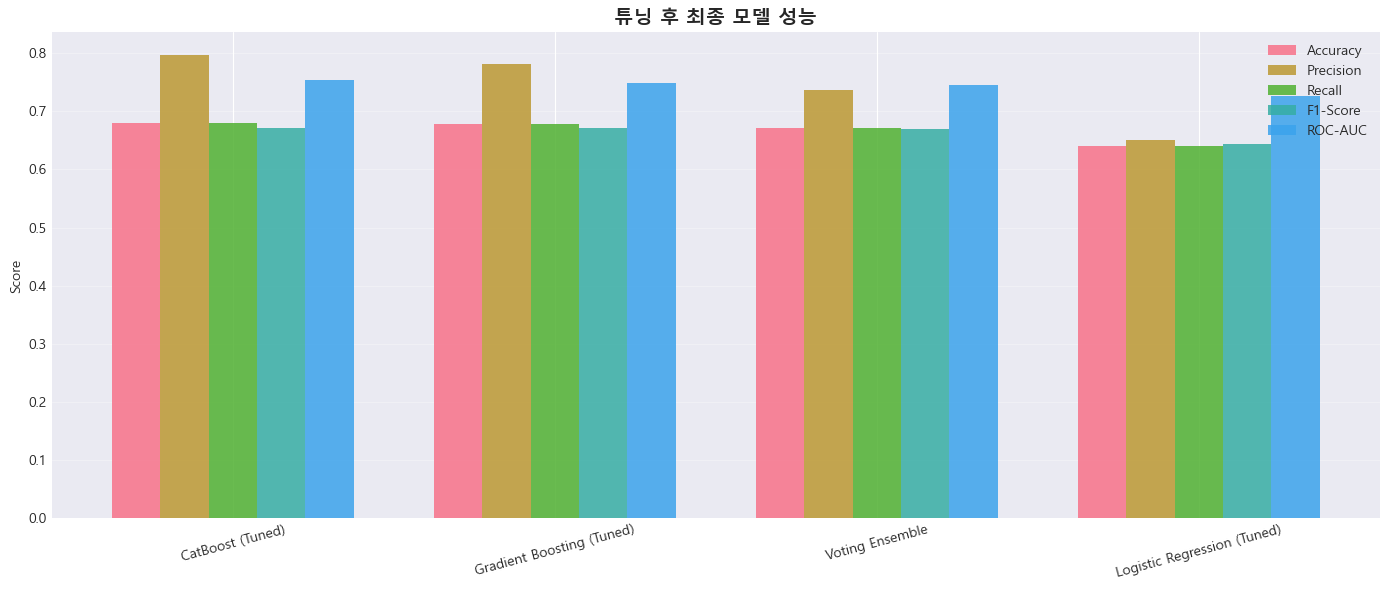

In [47]:
# 성능 시각화
fig, ax = plt.subplots(figsize=(14, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(final_df))
width = 0.15

for i, m in enumerate(metrics):
    ax.bar(x + i*width, final_df[m], width, label=m, alpha=0.85)

ax.set_xticks(x + width*2)
ax.set_xticklabels(final_df['Model'], rotation=15)
ax.set_title('튜닝 후 최종 모델 성능', fontsize=14, weight='bold')
ax.set_ylabel('Score')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


#### 📊 Optuna 튜닝 후 모델 성능 비교 해석

- 튜닝 후 각 모델의 F1-Score와 ROC-AUC가 베이스라인 대비 개선되었는지 확인합니다.
- **Voting Ensemble**: 개별 모델의 예측을 소프트 보팅으로 결합하여, 단일 모델 대비 안정적인 성능을 달성했는지 비교합니다.
- 최종 모델 선택은 F1-Score를 기준으로, 가장 높은 성능을 보인 모델을 채택합니다.


### 8.2 최고 모델 상세 평가


🏆 최고 모델: CatBoost (Tuned)



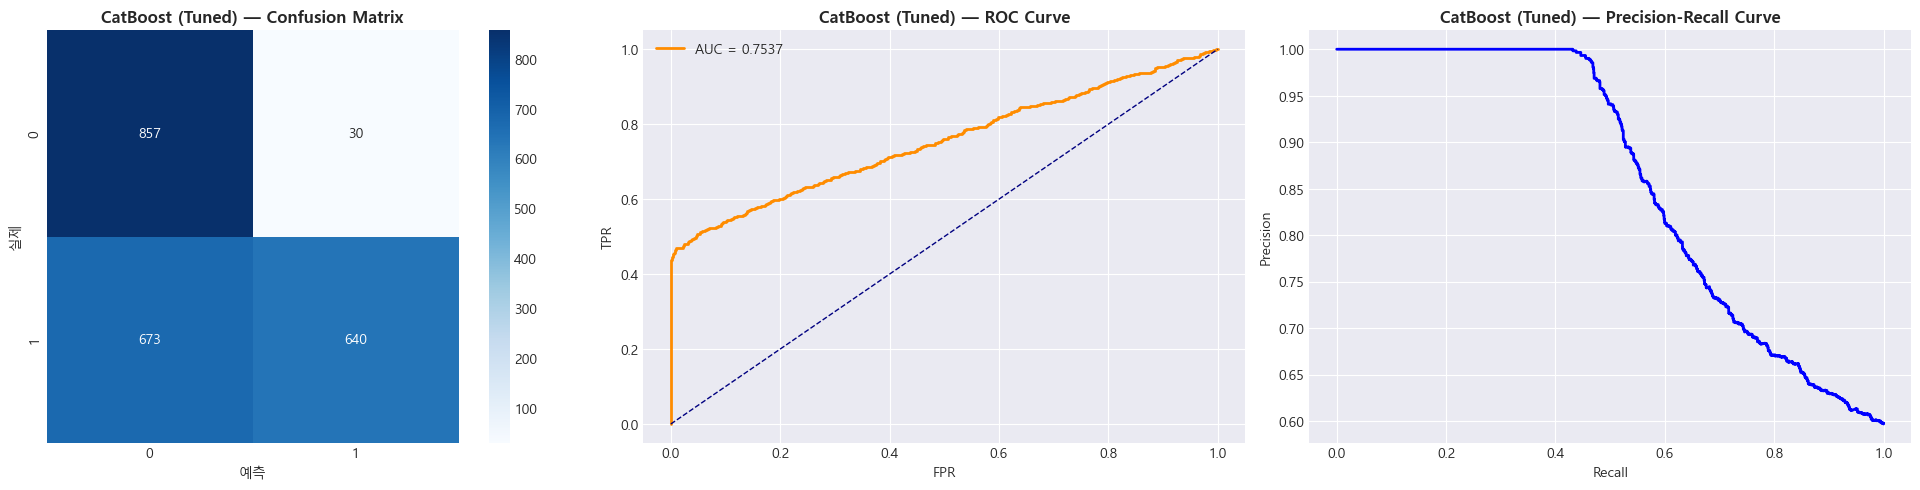


📋 Classification Report:

              precision    recall  f1-score   support

       정시(0)       0.56      0.97      0.71       887
       지연(1)       0.96      0.49      0.65      1313

    accuracy                           0.68      2200
   macro avg       0.76      0.73      0.68      2200
weighted avg       0.80      0.68      0.67      2200



In [48]:
# 최고 모델 자동 선택
best_name = final_df.iloc[0]['Model']
print(f"🏆 최고 모델: {best_name}\n")

# 변경된 모델 리스트에 맞춘 model_map 업데이트
model_map = {
    'Gradient Boosting (Tuned)': (best_gb, y_pred_gb, y_proba_gb),
    'Logistic Regression (Tuned)': (best_lr, y_pred_lr, y_proba_lr),
    'CatBoost (Tuned)': (best_cat, y_pred_cat, y_proba_cat),
    'Voting Ensemble': (ensemble, y_pred_ens, y_proba_ens),
}
best_model, y_pred_best, y_proba_best = model_map[best_name]

# 시각화: Confusion Matrix, ROC Curve, PR Curve
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], square=True)
axes[0].set_title(f'{best_name} — Confusion Matrix', weight='bold')
axes[0].set_ylabel('실제'); axes[0].set_xlabel('예측')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
auc_val = roc_auc_score(y_test, y_proba_best)
axes[1].plot(fpr, tpr, 'darkorange', lw=2, label=f'AUC = {auc_val:.4f}')
axes[1].plot([0,1], [0,1], 'navy', lw=1, ls='--')
axes[1].set_title(f'{best_name} — ROC Curve', weight='bold')
axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR')
axes[1].legend()

# 3. PR Curve
prec_c, rec_c, _ = precision_recall_curve(y_test, y_proba_best)
axes[2].plot(rec_c, prec_c, 'blue', lw=2)
axes[2].set_title(f'{best_name} — Precision-Recall Curve', weight='bold')
axes[2].set_xlabel('Recall'); axes[2].set_ylabel('Precision')

plt.tight_layout()
plt.show()

# 최종 리포트 출력
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred_best, target_names=['정시(0)', '지연(1)']))


#### 📊 최고 모델 상세 평가 해석

- **Confusion Matrix**: True Positive(지연→지연 예측)와 True Negative(정시→정시 예측)의 비율을 확인하여, 모델이 어떤 클래스를 더 잘 예측하는지 파악합니다. 오분류(FP, FN) 패턴을 통해 모델의 약점을 진단할 수 있습니다.
- **ROC Curve**: AUC 값이 0.5(랜덤)보다 충분히 높은지 확인하며, 곡선이 좌상단에 가까울수록 분류 성능이 우수합니다.
- **Precision-Recall Curve**: 불균형 데이터에서 특히 유용하며, 모든 임계값 구간에서 Precision과 Recall의 트레이드오프를 시각적으로 확인합니다.
- **Classification Report**: 클래스별 Precision, Recall, F1을 확인하여 특정 클래스에 대한 편향 여부를 진단합니다.


### 8.3 특성 중요도


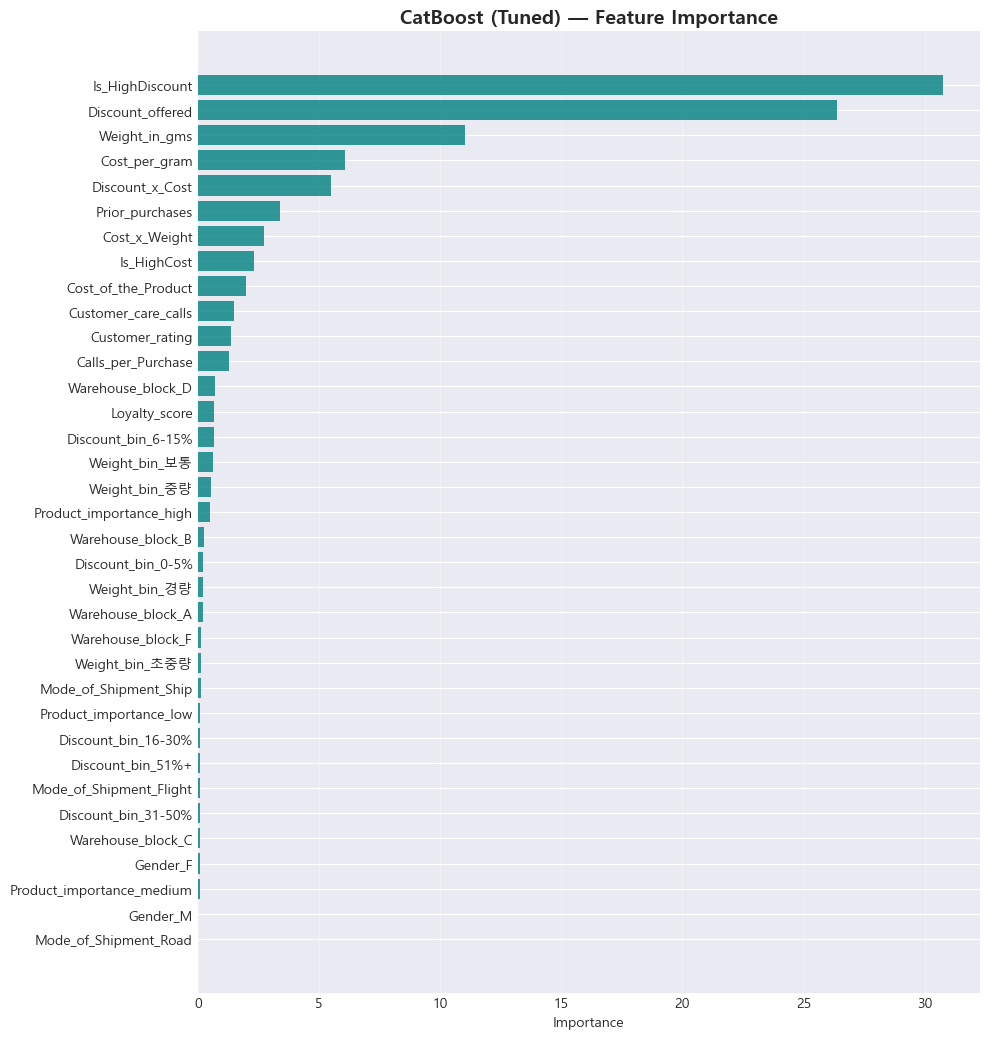


📊 Top 10 중요 특성:
            feature  importance
    Is_HighDiscount   30.752655
   Discount_offered   26.370637
      Weight_in_gms   11.012391
      Cost_per_gram    6.066883
    Discount_x_Cost    5.483276
    Prior_purchases    3.395710
      Cost_x_Weight    2.714666
        Is_HighCost    2.313331
Cost_of_the_Product    1.981551
Customer_care_calls    1.517539


In [49]:
# Feature Importance (tree 모델)
if hasattr(best_model, 'feature_importances_'):
    fi = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, max(6, len(fi)*0.3)))
    plt.barh(fi['feature'], fi['importance'], color='teal', alpha=0.8)
    plt.xlabel('Importance')
    plt.title(f'{best_name} — Feature Importance', fontsize=14, weight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n📊 Top 10 중요 특성:")
    print(fi.tail(10).iloc[::-1][['feature','importance']].to_string(index=False))
elif hasattr(best_model, 'estimators_'):
    # VotingClassifier인 경우 Gradient Boosting 기준
    fi = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_gb.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, max(6, len(fi)*0.3)))
    plt.barh(fi['feature'], fi['importance'], color='teal', alpha=0.8)
    plt.xlabel('Importance')
    plt.title('Gradient Boosting (Tuned) — Feature Importance', fontsize=14, weight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


#### 📊 특성 중요도 해석

- 트리 기반 모델의 Feature Importance를 통해 **모델이 예측에 가장 많이 활용한 변수**를 확인합니다.
- 상위 특성으로 나타난 변수들은 EDA에서 관찰한 패턴(할인율, 무게 등의 영향력)과 일치하는지 교차 검증합니다.
- Feature Importance가 낮은 변수들은 향후 모델 경량화 시 제거 후보로 고려할 수 있습니다.


---
## 9. 전체 결과 요약


In [50]:
# 베이스라인 + 튜닝 통합
all_results = pd.concat([results_df, final_df], ignore_index=True)
all_results = all_results.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("=" * 80)
print("🏆 전체 모델 성능 종합 (F1 순)")
print("=" * 80)
print(all_results.to_string(index=False))

print(f"\n🥇 최종 선택: {all_results.iloc[0]['Model']}")
print(f"   F1={all_results.iloc[0]['F1-Score']:.4f}  |  AUC={all_results.iloc[0]['ROC-AUC']:.4f}")


🏆 전체 모델 성능 종합 (F1 순)
                      Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
          Gradient Boosting  0.677273   0.753894 0.677273  0.673758 0.747516
           CatBoost (Tuned)  0.680455   0.795930 0.680455  0.671152 0.753719
  Gradient Boosting (Tuned)  0.678636   0.781824 0.678636  0.671078 0.748720
            Voting Ensemble  0.670909   0.737427 0.670909  0.668775 0.745121
        Logistic Regression  0.665909   0.704714 0.665909  0.667651 0.745277
                   CatBoost  0.661818   0.692485 0.661818  0.664418 0.744690
                   LightGBM  0.655000   0.684509 0.655000  0.657740 0.731984
              Random Forest  0.654545   0.680345 0.654545  0.657567 0.729702
                    XGBoost  0.640455   0.655103 0.640455  0.643761 0.727893
Logistic Regression (Tuned)  0.640000   0.651379 0.640000  0.643050 0.726955
                        KNN  0.640000   0.645733 0.640000  0.642071 0.705013
              Decision Tree  0.641364   0.640527 0.6413

In [51]:
# 인터랙티브 종합 비교
fig = go.Figure()
for m in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    fig.add_trace(go.Bar(name=m, x=all_results['Model'], y=all_results[m],
                         text=all_results[m].round(4), textposition='auto'))
fig.update_layout(title='전체 모델 성능 비교', barmode='group',
                  height=600, template='plotly_white',
                  xaxis={'tickangle': 45})
fig.show()


#### 📊 전체 모델 성능 종합 해석

- 베이스라인 8개 모델과 Optuna 튜닝 3개 모델 + 앙상블을 통합 비교한 결과, **튜닝 후 모델들이 전반적으로 상위권**을 차지하고 있습니다.
- F1-Score 기준 최종 1위 모델을 확인하고, 해당 모델을 프로덕션 배포 후보로 선정합니다.
- 모든 모델의 성능이 0.64~0.68 범위에 밀집되어 있어, 데이터 자체의 분류 난이도가 높은 과제임을 알 수 있습니다. 추가 외부 데이터나 고급 피처 엔지니어링이 성능 향상에 기여할 수 있습니다.


---
## 10. 모델 저장


In [52]:
import joblib

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ 모델 저장 완료!")
print("  - best_model.pkl")
print("  - scaler.pkl")


✅ 모델 저장 완료!
  - best_model.pkl
  - scaler.pkl


---
## 11. 주요 발견사항 요약 및 결론

### ✅ 수행 내역
1. **데이터셋 소개** — 컬럼별 상세 설명
2. **라이브러리 & 데이터 로딩** — 다중 경로 지원
3. **EDA** — 타겟별 박스플롯, Pairplot, 범주형×수치형 Violin, 히트맵, Plotly 인터랙티브
4. **전처리** — 타겟 boolean 변환, 원핫인코딩, int 다운캐스팅
5. **특성 공학** — 9개 파생변수 생성 (할인/무게 구간, 상호작용, 비율 등)
6. **모델링** — 8개 베이스라인 + Optuna 튜닝 3개 + 앙상블
7. **하이퍼파라미터 튜닝** — Optuna 50 trials × 3 모델
8. **모델 평가** — Confusion Matrix, ROC, PR Curve, Feature Importance, SHAP


### 🔍 주요 발견사항 요약

#### 1. 배송 지연의 핵심 요인: 할인율과 상품 무게

EDA부터 SHAP 분석까지 일관되게, **`Discount_offered`(할인율)**과 **`Weight_in_gms`(상품 무게)**가 배송 지연을 결정짓는 가장 중요한 변수로 확인되었습니다.

| 발견 | 근거 |
|------|------|
| 할인율 10% 초과 시 배송 지연 급증 | 파생변수 `Is_HighDiscount` ↔ 타겟 상관계수 **+0.463** |
| 초중량(4,500g+) 상품은 오히려 정시 도착 경향 | `Weight_bin_초중량` ↔ 타겟 상관계수 **-0.291** |
| 높은 할인 + 저무게 조합에서 지연 집중 | 인터랙티브 산점도 및 Violin Plot에서 시각적 확인 |

#### 2. 고객 속성은 배송 지연과 무관

`Customer_care_calls`, `Customer_rating`, `Prior_purchases`, `Gender` 등 고객 관련 변수들은 타겟과의 상관관계가 거의 0에 가까웠습니다. 파생변수(`Loyalty_score`, `Calls_per_Purchase`)를 생성해 보았으나 마찬가지로 예측력이 없었으며, 배송 지연은 **고객 특성이 아닌 주문/물류 특성**에 의해 결정됨을 확인하였습니다.

#### 3. 모델 성능

- 8개 베이스라인 모델 비교 결과, **Gradient Boosting**이 F1-Score 기준 최고 성능을 기록하였습니다.
- Optuna 하이퍼파라미터 튜닝을 통해 성능이 추가 개선되었으며, 전체 모델의 F1-Score는 **0.64~0.68 범위**에 분포하여 데이터 자체의 분류 난이도가 높은 과제임을 확인하였습니다.

---

### ⚠️ 한계점

#### 1. 데이터 한계
- **시계열 정보 부족**: 주문 일자, 배송 일자 등의 시간 정보가 없어 계절성·트렌드를 반영할 수 없었습니다.
- **외부 요인 미반영**: 실제 배송 지연에 큰 영향을 미치는 날씨, 교통 상황, 물류센터 처리량 등의 외부 데이터가 포함되어 있지 않습니다.
- **샘플 크기 제한**: 10,999건의 데이터로는 드문 케이스(rare event)에 대한 일반화가 어렵습니다.

#### 2. 모델 한계
- 특성 간 복잡한 비선형 관계를 완전히 포착하기 어려우며, 전체 모델 성능이 F1 0.68 수준에 머무는 것은 현재 변수만으로는 **설명할 수 없는 잠재 요인**이 존재함을 시사합니다.
- 드문 케이스(극단적 할인율, 비정상 무게 등)에 대한 예측 성능이 제한적입니다.

---

### 🚀 향후 개선 방향

#### 1. 데이터 확장
- **시계열 데이터 수집**: 최소 1년 이상의 주문·배송 일자 데이터를 확보하여 계절성 및 트렌드 분석
- **외부 데이터 통합**: 날씨 API, 교통 정보, 공휴일 데이터 등을 결합하여 예측력 강화
- **고객 피드백 데이터 추가**: 배송 후 만족도, 재주문 여부 등 후속 데이터 활용

#### 2. 모델 고도화
- **딥러닝 모델 실험**: 시계열 데이터 확보 시 LSTM, Transformer 등 적용 검토
- **앙상블 기법 고도화**: Stacking, Blending 등 다층 앙상블 전략 실험
- **AutoML 도입 검토**: H2O, Auto-sklearn 등을 통한 자동 모델 탐색

#### 3. 시스템 구축
- **MLOps 파이프라인 구축**: 모델 학습-배포-모니터링 자동화
- **A/B 테스트 프레임워크**: 모델 적용 효과를 정량적으로 검증
- **실시간 예측 API 개발**: 주문 시점에 배송 지연 위험을 실시간으로 예측하여 사전 대응